In [3333]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from pandas.plotting import lag_plot
import seaborn as sns

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)

# plt.style.use('dark_background')
# warnings.filterwarnings("ignore")

order = 3
borough = 'all'
window = 14
interpolation_method = 'spline'
use_log = False
stationary_method = 'diff'  # can be resid or diff or None

# Analysis of Real Estate Data and Covid in the Manhattan area

In [3334]:
# We first import the data
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df = rent_df.astype({
    'area': np.float64,
    'beds': np.float64,
    'baths': np.float64,
})
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id', 'living_area', 'lot_area', 'beds', 'baths', 'status_type', 'zip_code'], axis=1)

In [3335]:
# read the data
sales_df = pd.read_csv("data/real_estate/fresh_sales_data.csv", parse_dates=True)
sales_df = sales_df.replace('None', np.nan)

# get the date in the right format
sales_df['date'] = pd.to_datetime(sales_df['date'], utc=False)
sales_df = sales_df.astype({'area': np.float64})
# we decided to ignore date_sold for the moment.
# sales_df['date_sold'] = pd.to_datetime(sales_df['date_sold'])

sales_df = sales_df.rename({"BOROUGH": "borough"}, axis=1)
sales_df.drop_duplicates(['zillow_id', 'price', 'date'])
sales_df = sales_df.drop(['date_sold', 'home_type', 'zillow_id', 'living_area', 'lot_area', 'beds', 'baths', 'zip_code'], axis=1)

sales_df = sales_df[sales_df['status_type'] == 'SOLD']
sales_df.drop(sales_df[sales_df['date'] == float('nan')].index, inplace=True)

In [3336]:
rent_df.head()

,date,event_description,price,address_city,area,home_type,borough
0,2021-04-16,Listed for rent,1500,Maspeth,NaN,APARTMENT,queens
1,2021-03-03,Price change,1300,Maspeth,350.0,APARTMENT,queens
2,2021-02-17,Listed for rent,1350,Maspeth,350.0,APARTMENT,queens
3,2021-04-10,Listed for rent,3000,Maspeth,NaN,MULTI_FAMILY,queens
4,2021-03-23,Listed for rent,3200,Flushing,3000.0,SINGLE_FAMILY,queens


In [3337]:
sales_df.head()

,date,event_description,price,address_city,area,status_type,borough
9,2018-11-30,Listing removed,739900,Glendale,1296.0,SOLD,queens
10,2018-09-10,Listed for sale,739900,Glendale,1296.0,SOLD,queens
22,2018-12-01,Listing removed,865000,Staten Island,2548.0,SOLD,staten_island
23,2018-09-24,Pending sale,865000,Staten Island,2548.0,SOLD,staten_island
24,2018-09-21,Price change,865000,Staten Island,2548.0,SOLD,staten_island


The structure of the data is:

We divide the data into boroughs to analyze them individually

In [3338]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

sales_ny = {
    'queens': sales_df[sales_df['borough'] == 'queens'],
    'bronx': sales_df[sales_df['borough'] == 'bronx'],
    'brooklyn': sales_df[sales_df['borough'] == 'brooklyn'],
    'staten': sales_df[sales_df['borough'] == 'staten_island'],
    'manhattan': sales_df[sales_df['borough'] == 'manhattan'],
}

# Time Series Analysis on Manhattan

In [3339]:
if borough == 'all':
    pass
else:
    sales_df = sales_ny[borough]
    rent_df = rent_ny[borough]


<AxesSubplot:xlabel='price'>

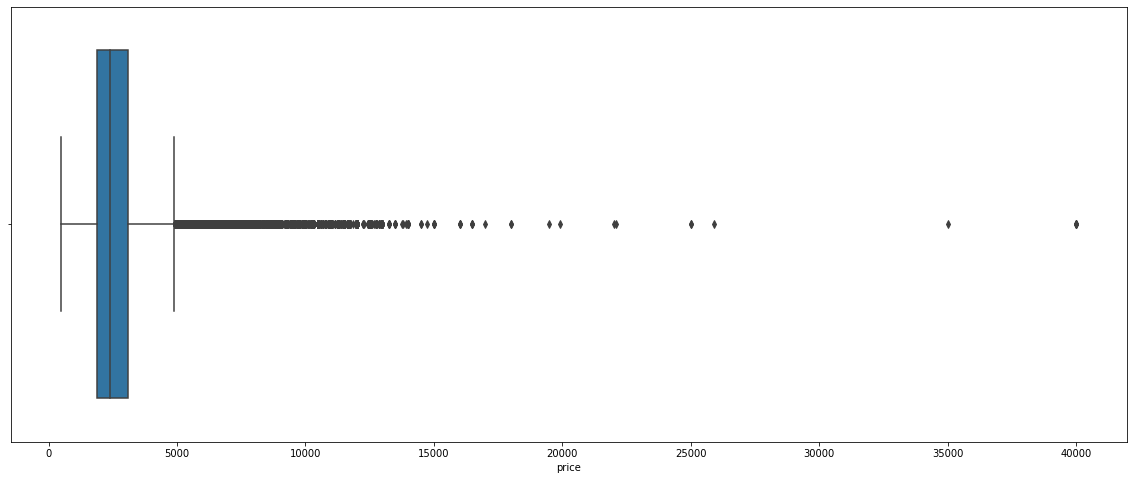

In [3340]:
sns.boxplot(x=rent_df['price'])

<AxesSubplot:xlabel='price'>

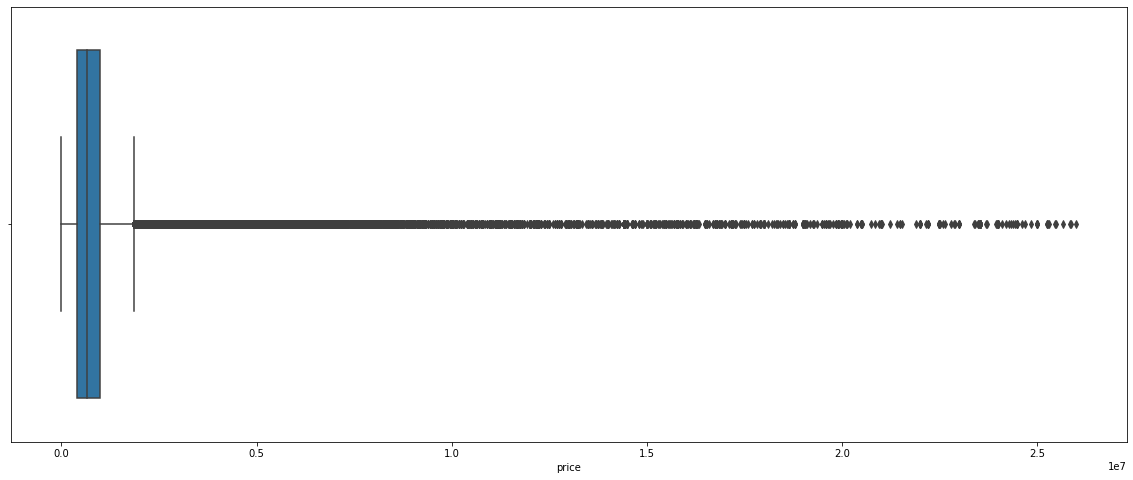

In [3341]:
sns.boxplot(x=sales_df['price'])

Remove outliers from the rent data

In [3342]:
Q1 = rent_df.quantile(0.25)
Q3 = rent_df.quantile(0.75)
IQR = Q3 - Q1
print((Q1 - 1.5 * IQR), "\n\n")
print((Q3 + 1.5 * IQR))

price    100.000
area     -76.875
dtype: float64 


price    4900.000
area     1886.125
dtype: float64


Statistics before removing outliers:

In [3343]:
rent_df.describe()

,price,area
count,48321.000000,22394.000000
mean,2907.242524,3502.652541
std,1761.476294,25697.415999
min,500.000000,10.000000
25%,1900.000000,659.250000
50%,2400.000000,850.000000
75%,3100.000000,1150.000000
max,40000.000000,759187.000000


In [3344]:
# removing outliers
rent_df = rent_df[rent_df['price'] <= (Q3+1.5*IQR)['price']]

<AxesSubplot:xlabel='price'>

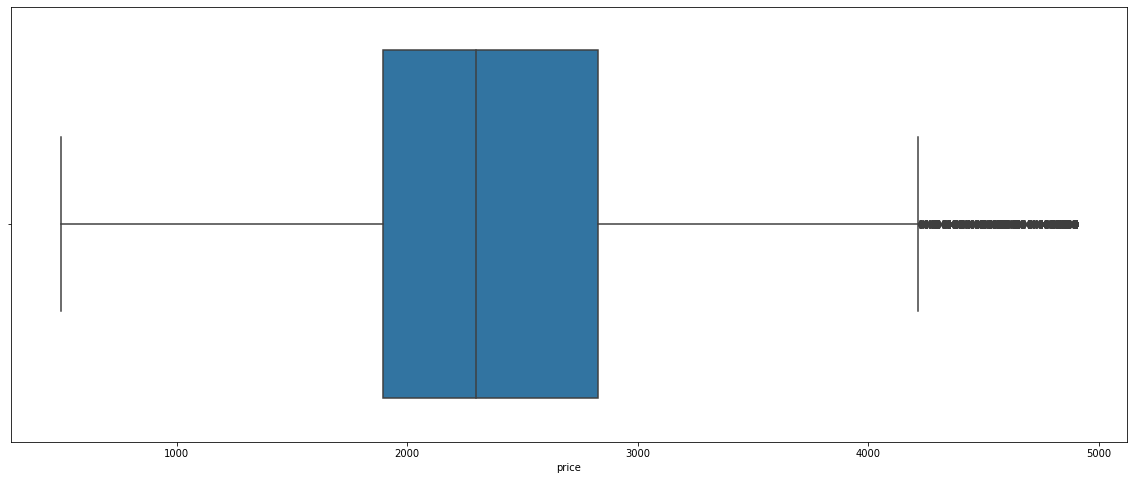

In [3345]:
sns.boxplot(x=rent_df['price'])

Statistics after removing outliers:

In [3346]:
rent_df.describe()

,price,area
count,43893.000000,19219.000000
mean,2456.748775,3284.362766
std,760.131542,23975.123359
min,500.000000,10.000000
25%,1895.000000,648.000000
50%,2300.000000,800.000000
75%,2825.000000,1000.000000
max,4900.000000,759187.000000


Remove outliers from the sales data

In [3347]:
Q1 = sales_df.quantile(0.25)
Q3 = sales_df.quantile(0.75)
IQR = Q3 - Q1
print((Q1 - 1.5 * IQR), "\n\n")
print((Q3 + 1.5 * IQR))

price   -460000.0
area      -1100.0
dtype: float64 


price    1860000.0
area        4500.0
dtype: float64


Statistics before removing outliers:

In [3348]:
sales_df.describe()

,price,area
count,1.611710e+05,1.235830e+05
mean,9.791677e+05,1.142939e+04
std,1.453830e+06,5.809643e+04
min,1.000000e+00,1.000000e+00
25%,4.100000e+05,1.000000e+03
50%,6.500000e+05,1.511000e+03
75%,9.900000e+05,2.400000e+03
max,2.600000e+07,8.737452e+06


In [3349]:
sales_df = sales_df[sales_df['price'] <= (Q3+1.5*IQR)['price']]

Statistics after removing outliers:

<AxesSubplot:xlabel='price'>

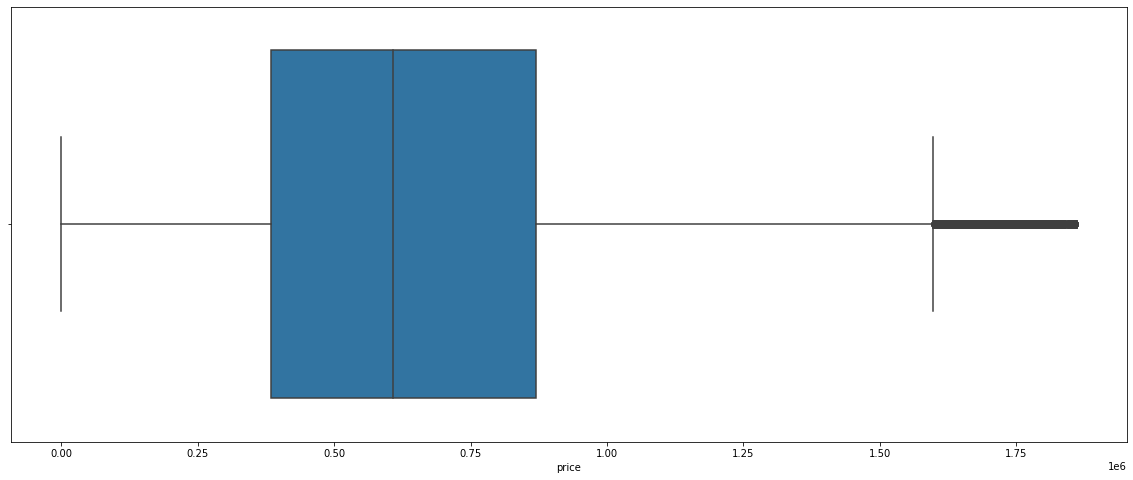

In [3350]:
sns.boxplot(x=sales_df['price'])

In [3351]:
sales_df.describe()

,price,area
count,1.464980e+05,1.125690e+05
mean,6.671018e+05,1.109111e+04
std,3.897556e+05,5.833648e+04
min,1.000000e+00,1.000000e+00
25%,3.850000e+05,9.730000e+02
50%,6.075000e+05,1.440000e+03
75%,8.700000e+05,2.270000e+03
max,1.860000e+06,8.737452e+06


In [3352]:
# rent_df.drop(rent_df[rent_df['price'] > 7_000].index, inplace=True)
# rent_df.drop(rent_df[rent_df['price'] < 500].index, inplace=True)
#
# sales_df.drop(sales_df[sales_df['price'] > 7_000_000].index, inplace=True)
# sales_df.drop(sales_df[sales_df['price'] < 20_000].index, inplace=True)

# Create a time series out of the real estate data

In [3353]:
# Create a time series for average price, median price, and count  from the manhattan dataframe

rent_ts = rent_df.groupby(rent_df.date)['price'].agg(['mean','count'])
sales_ts = sales_df.groupby(sales_df.date)['price'].agg(['mean','count'])

In [3354]:
sales_ts.index = sales_ts.index.normalize()
sales_ts

start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 4, 1)
idx = pd.date_range(start, end)

rent_ts = rent_ts[(rent_ts.index >= start) & (rent_ts.index <= end)]
sales_ts = sales_ts[(sales_ts.index >= start) & (sales_ts.index <= end)]
rent_ts = rent_ts.reindex(index=pd.date_range(start, end))
sales_ts = sales_ts.reindex(index=pd.date_range(start, end))
sales_ts = sales_ts.rename({
    'mean': 'mean_selling_price',
    'count': 'sales_count',
}, axis=1)

rent_ts = rent_ts.rename({
    'mean': 'mean_rent_price',
    'count': 'rent_count',
}, axis=1)

# Missing Values

In [3355]:
print(rent_ts.isna().sum(), "\n\n")
print(sales_ts.isna().sum())

mean_rent_price    4
rent_count         4
dtype: int64 


mean_selling_price    13
sales_count           13
dtype: int64


Raw time series for Manhattan's Renting Market

<AxesSubplot:>

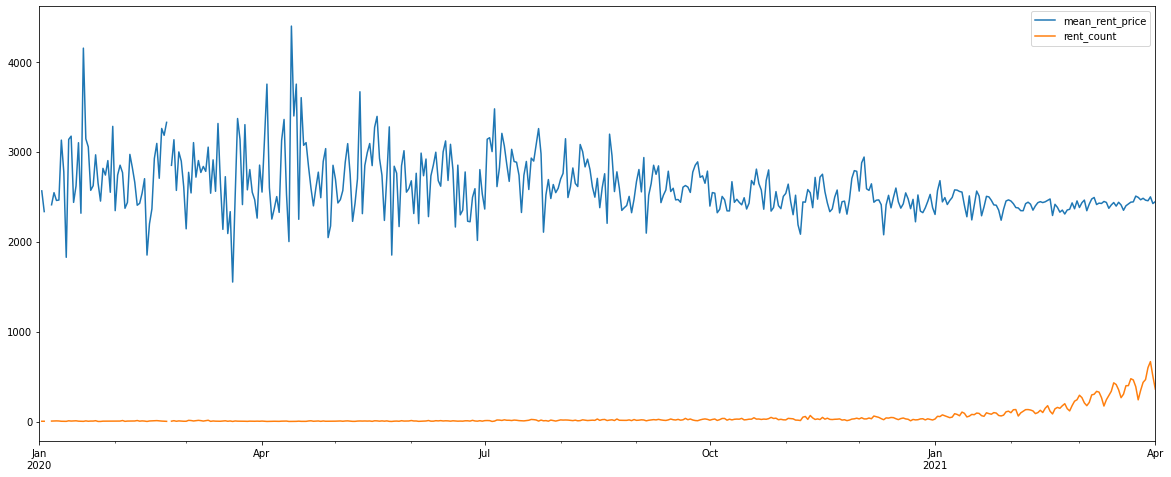

In [3356]:
rent_ts.plot()

Raw time series for Manhattan's Selling Market

<AxesSubplot:>

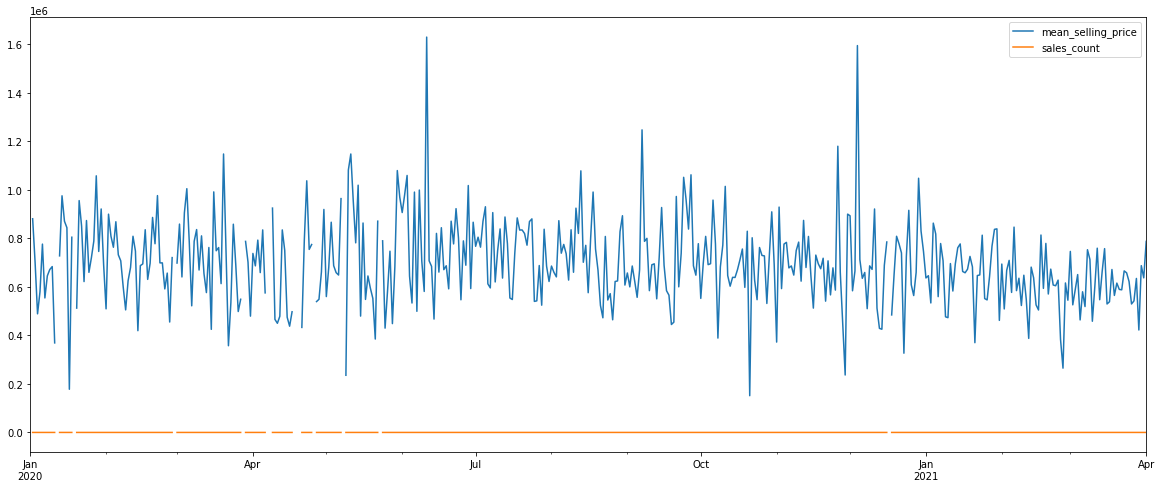

In [3357]:
sales_ts.plot()

In [3358]:
# combine sales and rent into one time series
re_ts = pd.concat([rent_ts, sales_ts], axis=1)

We need to fill in missing values. We use interpolation to do so.

# Interpolation

This is a comparison between the different interpolation methods.

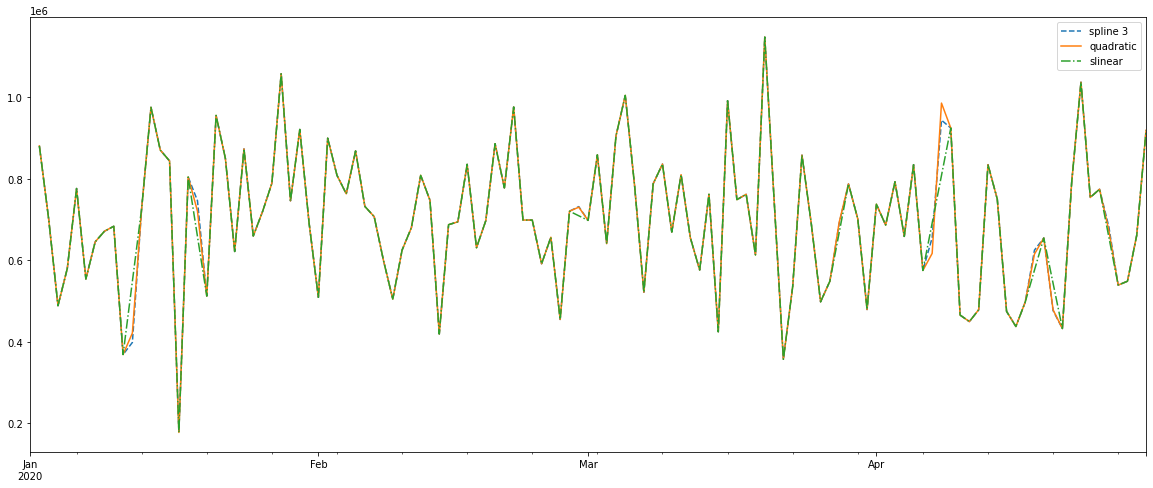

In [3359]:
fig, ax = plt.subplots()
re_ts_1 = re_ts.interpolate(method='spline', order=order)
re_ts_1['2020/1':'2020/4']['mean_selling_price'].plot(style='--', legend=True, ax=ax)
re_ts_2 = re_ts.interpolate(method='quadratic')
re_ts_2['2020/1':'2020/4']['mean_selling_price'].plot(style='-', legend=True, ax=ax)
re_ts_4 = re_ts.interpolate(method='slinear')
re_ts_4['2020/1':'2020/4']['mean_selling_price'].plot(style='-.', legend=True, ax=ax)
ax.legend([f"spline {order}", "quadratic", "slinear"])

We choose to use the slinear method of interpolation

In [3360]:
re_ts = re_ts.interpolate(method=interpolation_method, order=order)

# Normalization

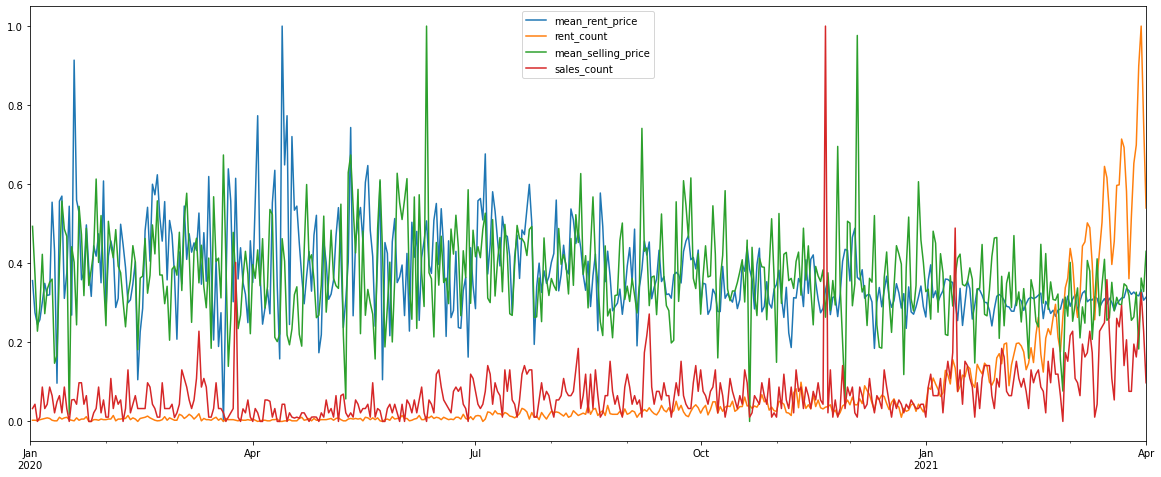

In [3361]:
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler()
# scaler = StandardScaler()

re_ts_norm = pd.DataFrame(scaler.fit_transform(re_ts), index=re_ts.index, columns=re_ts.columns)
re_ts_norm.plot()
re_ts = re_ts_norm


# Smoothing
Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.
We might need to use a trailing window because we are trying to forecast into the future.

Comparison between different smoothing options:

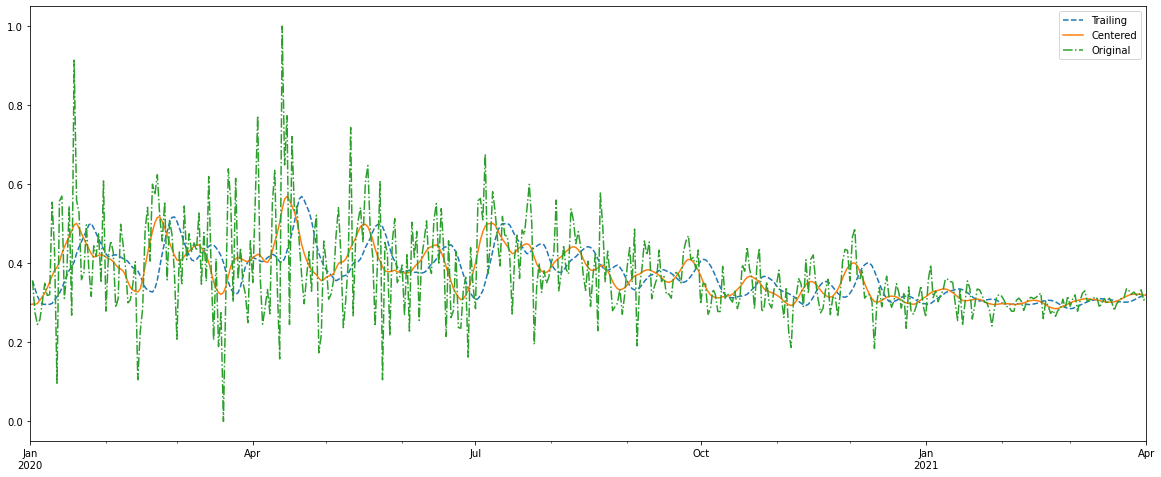

In [3362]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

re_ts = re_ts_norm
fig, ax = plt.subplots()
smoothed_ts = re_ts.rolling(window, win_type='triang', min_periods=1).mean()
smoothed_ts['mean_rent_price'].plot(style='--', legend=True, ax=ax)
smoothed_ts_centered = re_ts.rolling(window, win_type='triang', min_periods=1, center=True).mean()
smoothed_ts_centered['mean_rent_price'].plot(legend=True, ax=ax)
smoothed_ts_not_smoothed = re_ts
smoothed_ts_not_smoothed['mean_rent_price'].plot(style='-.', legend=True, ax=ax)
ax.legend(["Trailing", "Centered", "Original"])

# We decided to wo with the trailling window.
re_ts = re_ts.rolling(7, win_type='triang', min_periods=1).mean()

Transformed real estate data:

<AxesSubplot:>

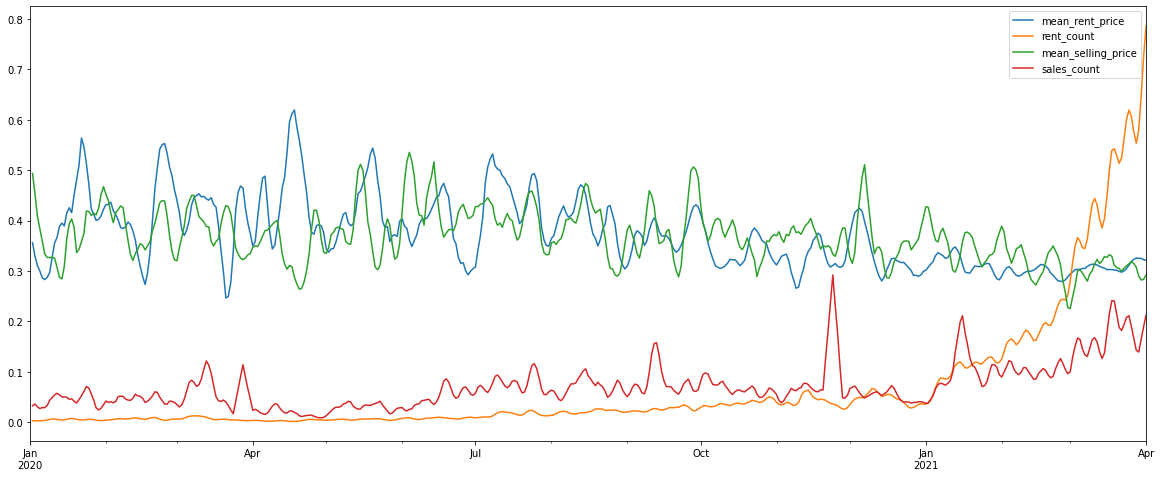

In [3363]:
re_ts.plot()

# Feature Engineering
We also explore the price/sqr_feet

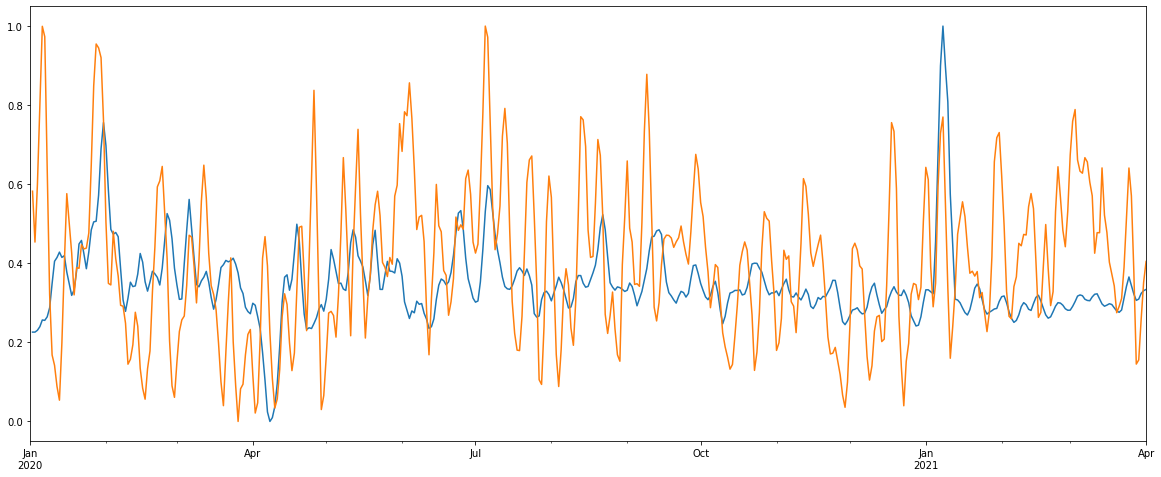

In [3364]:
x = ['rent', 'selling']
for i, df in enumerate([rent_df, sales_df]):
    # we take the properties that actually have the area listed
    price_sqft = df[ ~df['area'].isna() ].sort_values('date')
    price_sqft['price_per_sqft'] = price_sqft['price']/price_sqft['area']

    price_sqft = price_sqft.groupby(price_sqft.date)['price_per_sqft'].agg(['mean'])
    price_sqft = price_sqft.rename({
        'mean': f"mean_{x[i]}_price_per_sqft",
    }, axis=1)
    price_sqft = price_sqft.reindex(idx)
    price_sqft = price_sqft.interpolate(method='slinear', order=5)
    price_sqft = price_sqft.rolling(5, win_type='triang', min_periods=1).mean()
    price_sqft = pd.DataFrame(scaler.fit_transform(price_sqft), index=price_sqft.index, columns=price_sqft.columns)
    price_sqft[f"mean_{x[i]}_price_per_sqft"].plot()
    re_ts = pd.concat([re_ts, price_sqft], axis=1)

# COVID-19 data

In [3365]:
# get the data
nyc_covid_df = pd.read_csv("data/covid/covid_nyc.csv")
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])

# drop columns that we don't want to explore
nyc_covid_df.drop(['city_pop2019', 'cityname', 'statename', 'statefips'], axis=1, inplace=True)
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]

nyc_covid_ts = nyc_covid_df.set_index('date', drop=True)
nyc_covid_ts = nyc_covid_ts.rename({col: col + "_covid" for col in nyc_covid_ts.columns}, axis=1)
nyc_covid_ts['2020/4'].head()

<ipython-input-3365-e902b8cd1a10>:12: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  nyc_covid_ts['2020/4'].head()


,new_case_count_covid,new_death_count_covid,new_test_count_covid,new_case_rate_covid,new_death_rate_covid,new_test_rate_covid,case_count_covid,case_rate_covid,death_count_covid,death_rate_covid,test_count_covid,test_rate_covid
date,,,,,,,,,,,,
2020-04-01,3671,156,8509,44.0,1.87,102.0,34035,408.0,806,9.67,99970,1199.0
2020-04-02,3799,171,8611,45.6,2.05,103.0,37834,454.0,977,11.70,108581,1302.0
2020-04-03,4611,202,8878,55.3,2.43,106.0,42445,509.0,1179,14.10,117459,1409.0
2020-04-04,4654,226,8948,55.8,2.71,107.0,47099,565.0,1405,16.90,126407,1516.0
2020-04-05,4873,300,9103,58.5,3.60,109.0,51972,623.0,1705,20.50,135510,1625.0


# Normalizing Covid Data

In [3366]:
# nyc_covid_ts = pd.DataFrame(scaler.fit_transform(nyc_covid_ts), columns=nyc_covid_ts.columns, index=nyc_covid_ts.index)
# nyc_covid_ts.plot()

# Log transform
We can apply the log transform to make the covid data linear.

We tried using the logarithm but we ended up leaving it as is because we get better results that way.

<AxesSubplot:xlabel='date'>

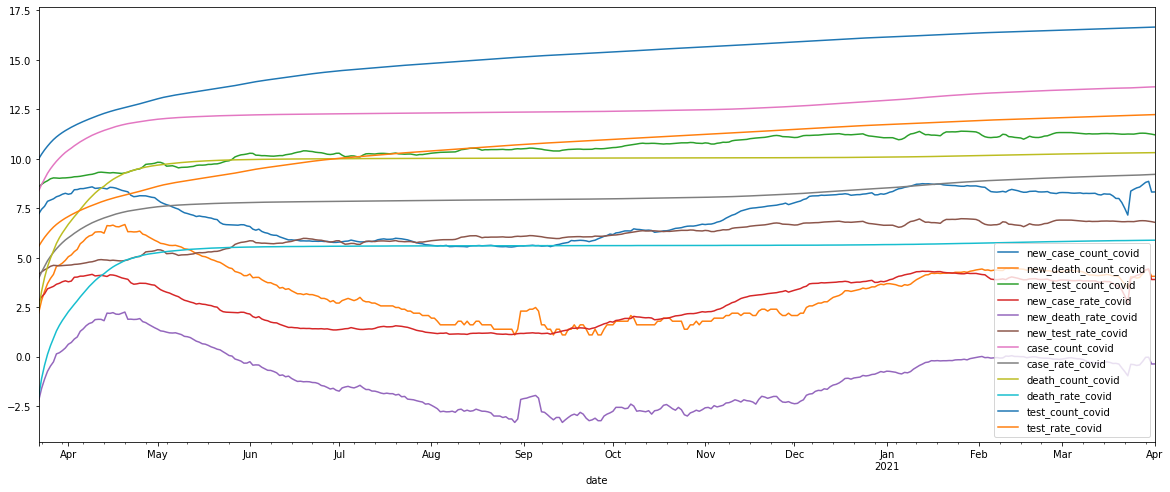

In [3367]:
nyc_covid_log_ts = np.log(nyc_covid_ts).replace(float('-inf'), float('NaN')).dropna()
# nyc_covid_log_ts.rename({x : x+"_log" for x in nyc_covid_ts.columns}, axis=1, inplace=True)
nyc_covid_log_ts.plot()

In [3368]:
if use_log:
    ts = pd.concat([re_ts, nyc_covid_log_ts], axis=1).fillna(0)
else:
    ts = pd.concat([re_ts, nyc_covid_ts], axis=1).fillna(0)
ts

,mean_rent_price,rent_count,mean_selling_price,sales_count,mean_rent_price_per_sqft,mean_selling_price_per_sqft,new_case_count_covid,...,new_test_rate_covid,case_count_covid,case_rate_covid,death_count_covid,death_rate_covid,test_count_covid,test_rate_covid
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.356180,0.003008,0.493423,0.032609,0.225942,0.582345,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.329233,0.003008,0.452928,0.036232,0.225942,0.453693,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.310763,0.002871,0.408741,0.030797,0.230543,0.599558,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.299867,0.002973,0.383595,0.027174,0.239745,0.802090,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,0.325537,0.553195,0.307207,0.142663,0.306222,0.145069,5962.0,...,965.0,814309.0,9768.0,29772.0,357.0,16823590.0,201799.0
2021-03-29,0.325177,0.579417,0.290089,0.139266,0.309407,0.155583,6693.0,...,959.0,821002.0,9848.0,29853.0,358.0,16903538.0,202758.0
2021-03-30,0.324950,0.647932,0.282119,0.165082,0.323846,0.259050,7047.0,...,940.0,828049.0,9932.0,29934.0,359.0,16981932.0,203698.0
2021-03-31,0.322558,0.725376,0.283392,0.189538,0.330680,0.351783,4107.0,...,918.0,832156.0,9982.0,29991.0,360.0,17058430.0,204616.0


# Initial Look at The Relationship

### KDE plots

Mean rent Price:

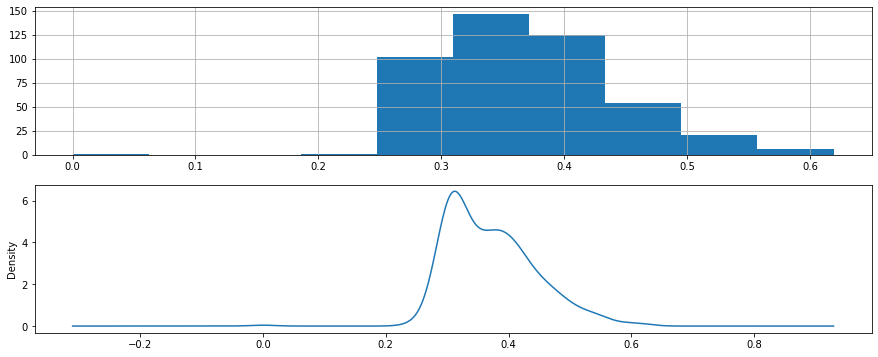

In [3369]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
ts["mean_rent_price"].hist()
plt.subplot(212)
ts["mean_rent_price"].plot(kind='kde')
plt.show()

COVID-19 case rate:

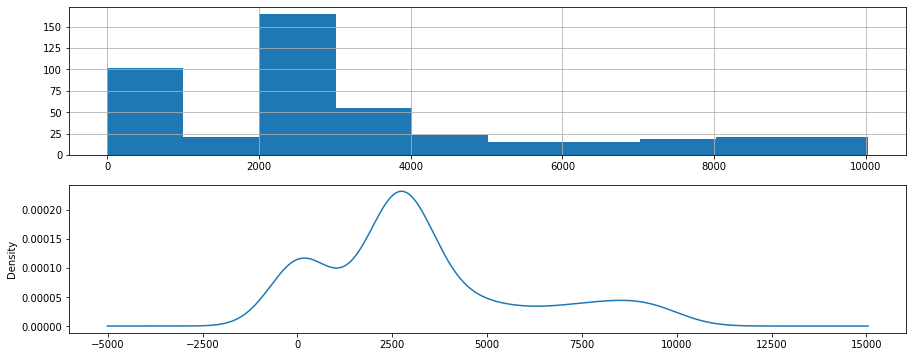

In [3370]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
ts["case_rate_covid"].hist()
plt.subplot(212)
ts["case_rate_covid"].plot(kind='kde')
plt.show()


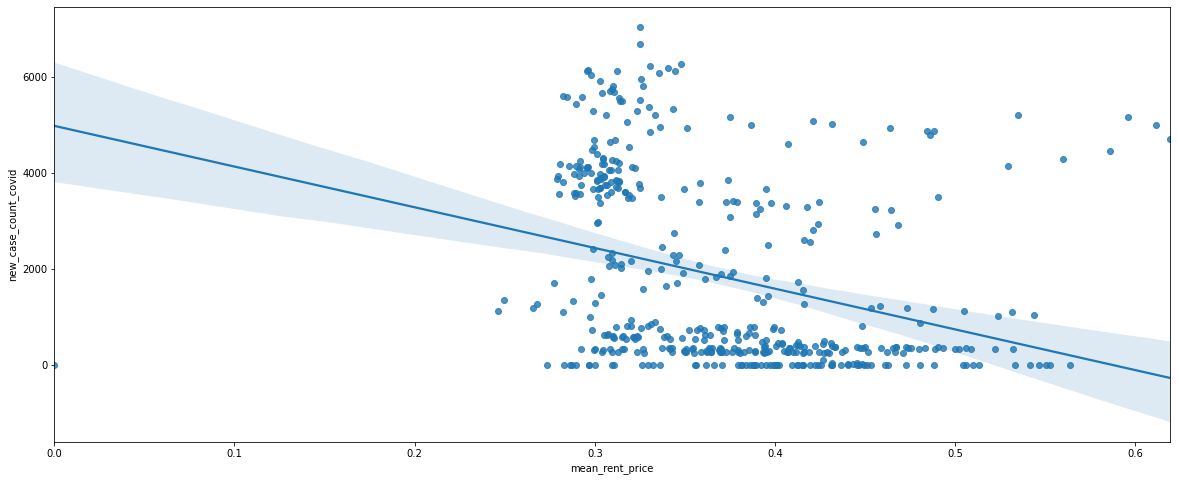

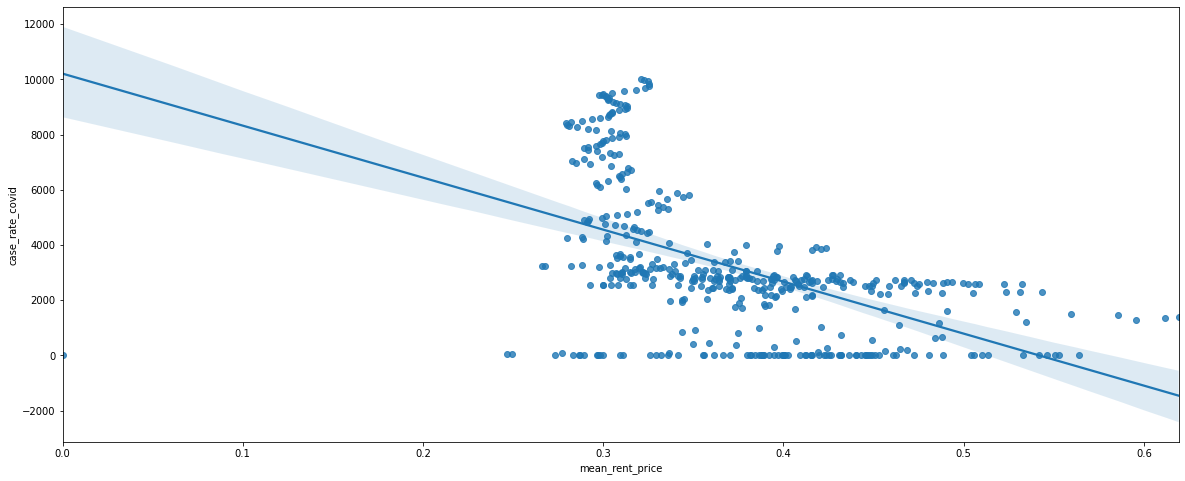

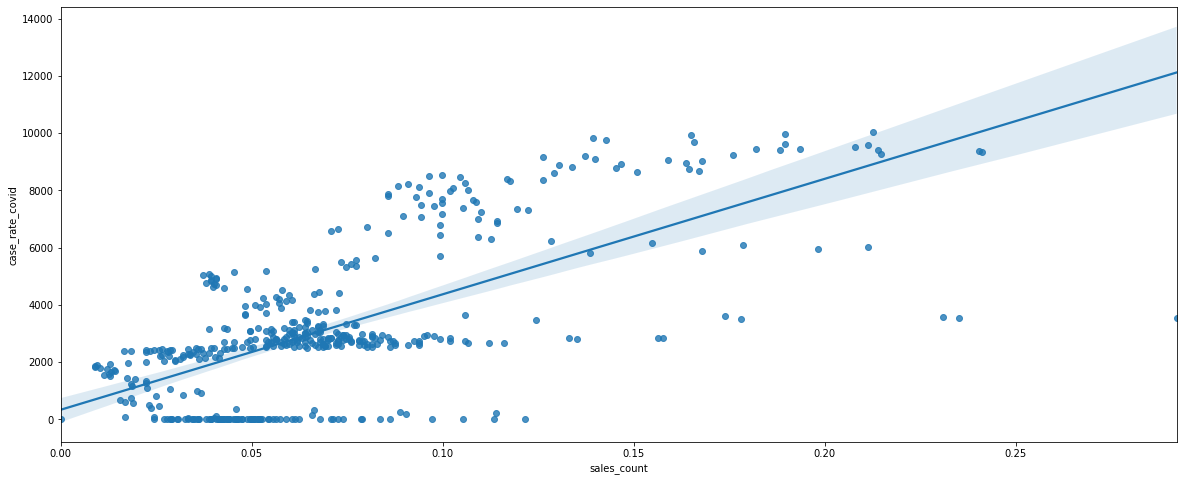

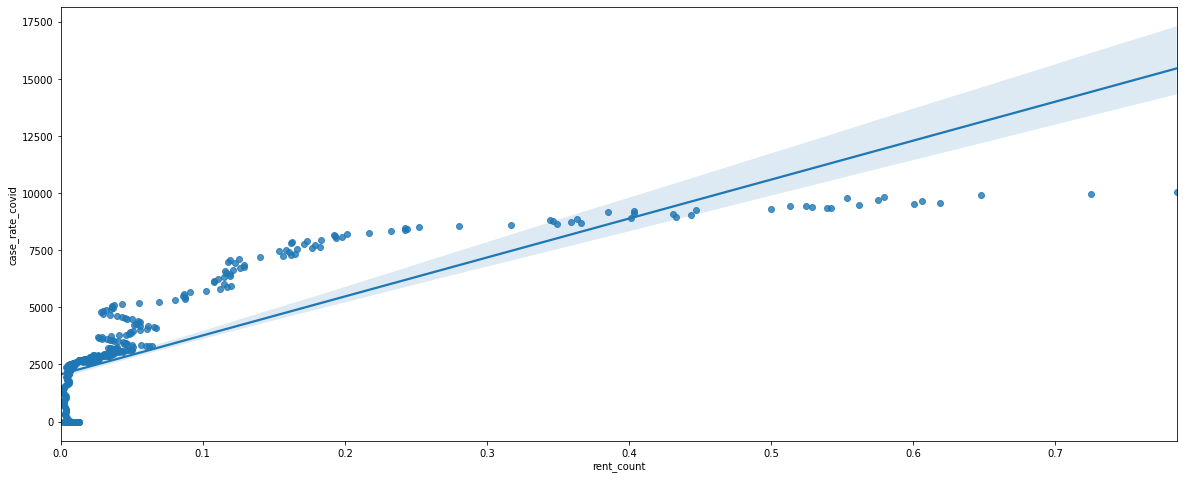

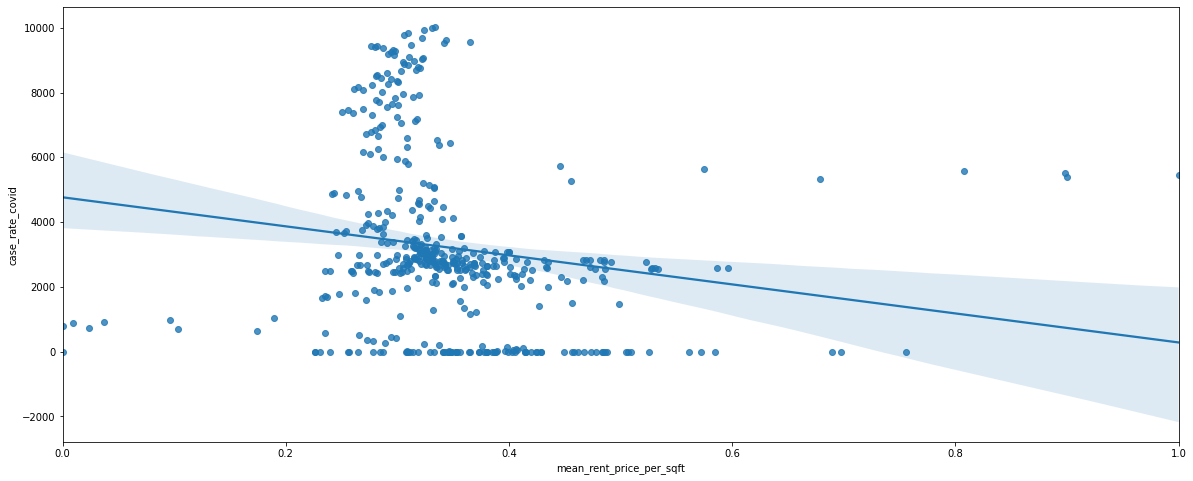

In [3371]:
sns.regplot(y='new_case_count_covid', x='mean_rent_price', data=ts)
plt.show()
sns.regplot(y='case_rate_covid', x='mean_rent_price', data=ts)
plt.show()
sns.regplot(y='case_rate_covid', x='sales_count', data=ts)
plt.show()
sns.regplot(y='case_rate_covid', x='rent_count', data=ts)
plt.show()
sns.regplot(y='case_rate_covid', x='mean_rent_price_per_sqft', data=ts)
plt.show()

# Seasonal Decompositions
Decomposition is the process of understanding generalizations and problems related to time-series forecasting.
We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend,
cyclic, and irregular variations.

First we explore the decompositions of COVID time series. But It might not be a good idea to keep the residuals
of these decompositions since covid is not a seasonal process


In [3372]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals = dict()
legend = []
for col in ts.columns:
    legend.append(col)
    covid_df = ts[col]
    covid_decomposition = seasonal_decompose(covid_df.drop(covid_df[covid_df.isna()].index), model='additive')
    residuals[col+'_resid'] = covid_decomposition.resid.rolling(7, win_type='triang', min_periods=1).mean()
residuals_ts = pd.concat(residuals, axis=1)

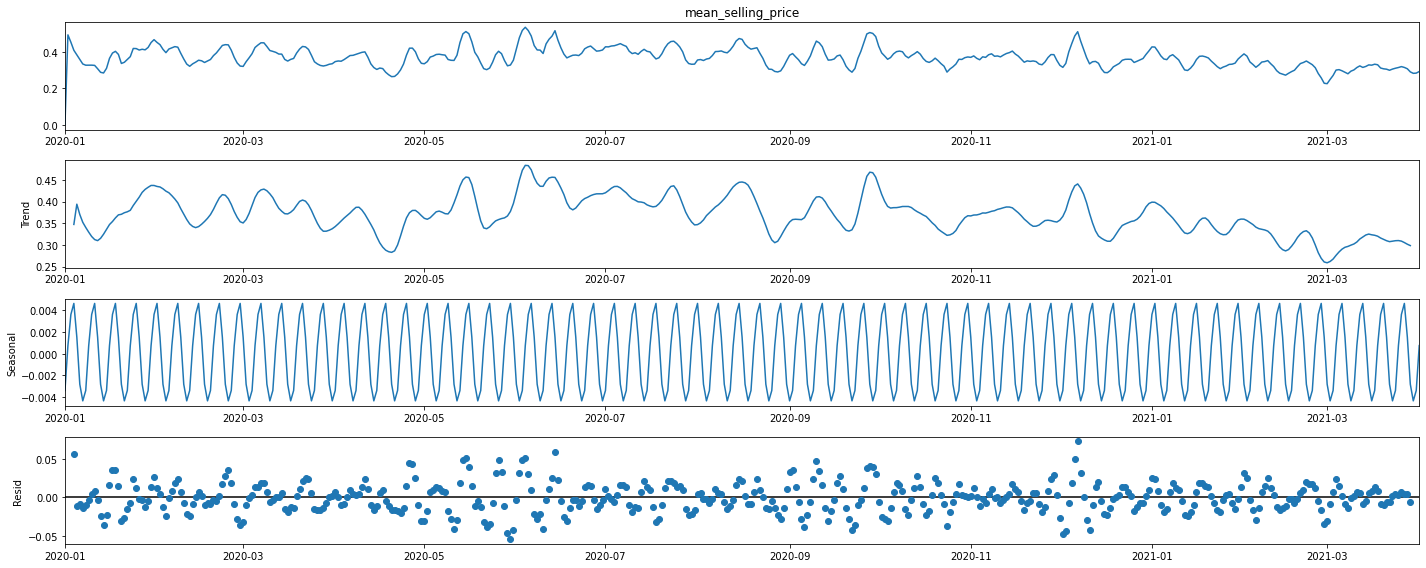

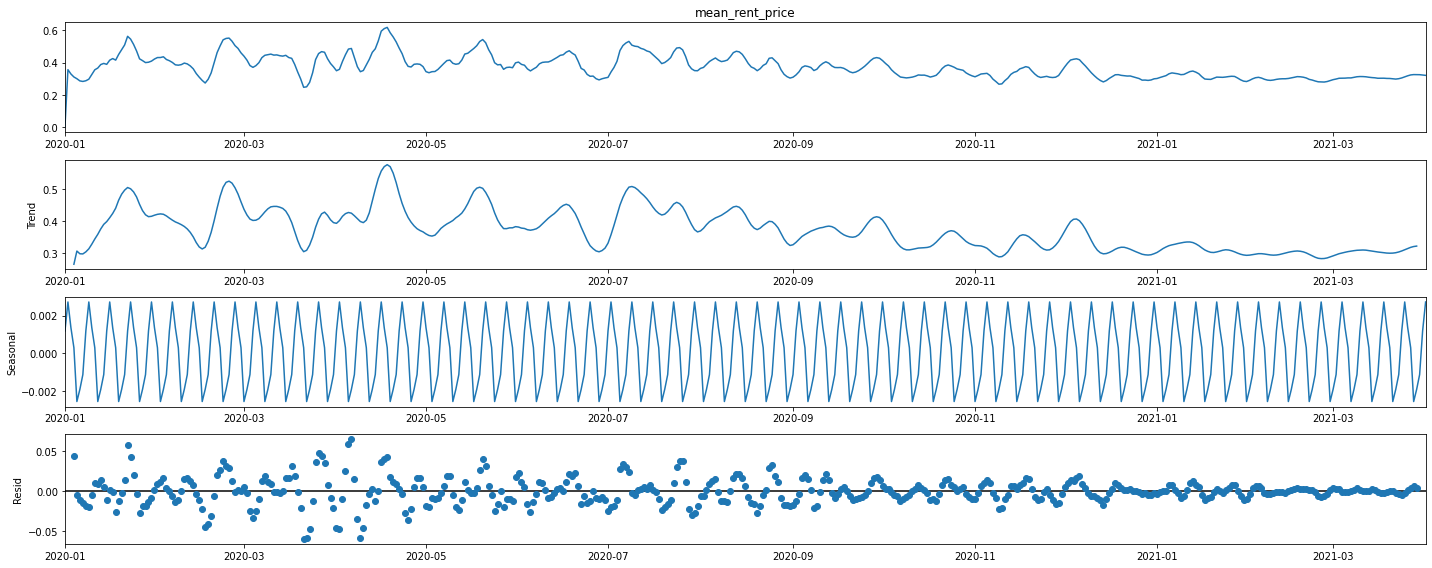

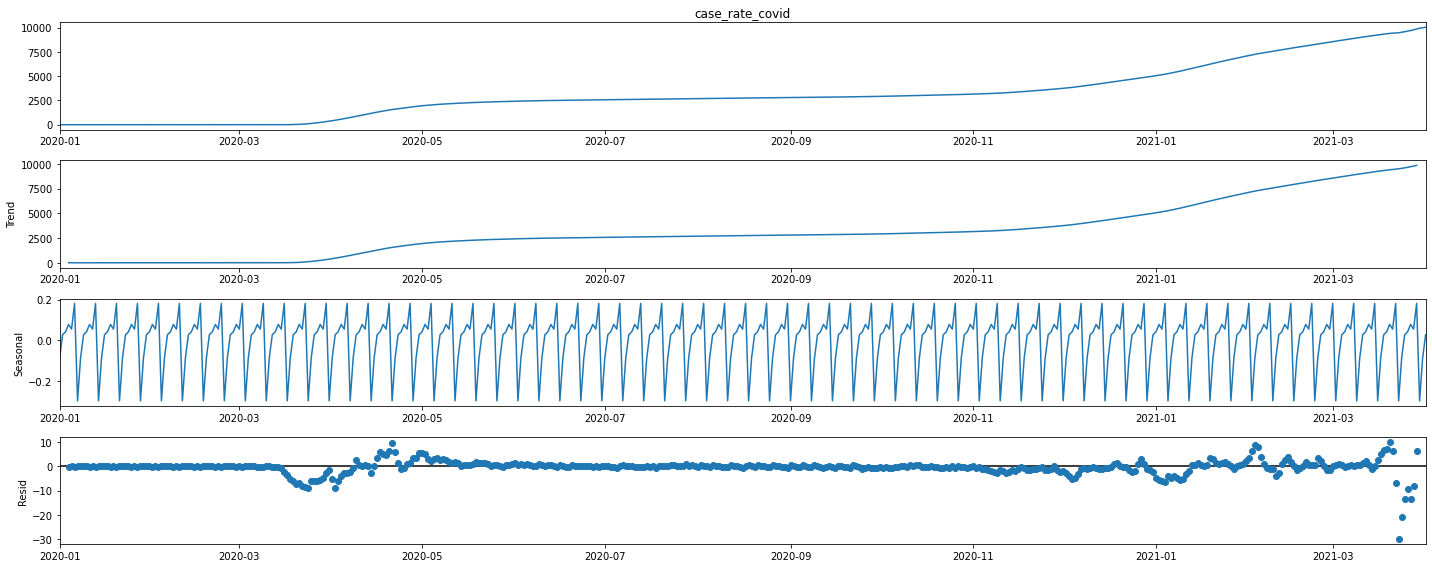

In [3373]:
for col in ['mean_selling_price', 'mean_rent_price', 'case_rate_covid']:
    col_df = ts[col]
    decomp = seasonal_decompose(col_df.drop(col_df[col_df.isna()].index), model='additive')
    decomp.plot()
    plt.show()

# Autocorrelation plots
Autocorrelation is used to check randomness in data. It helps to identify types of data where the period is not known.

https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show]

Autocorrelation plot for covid case rate


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


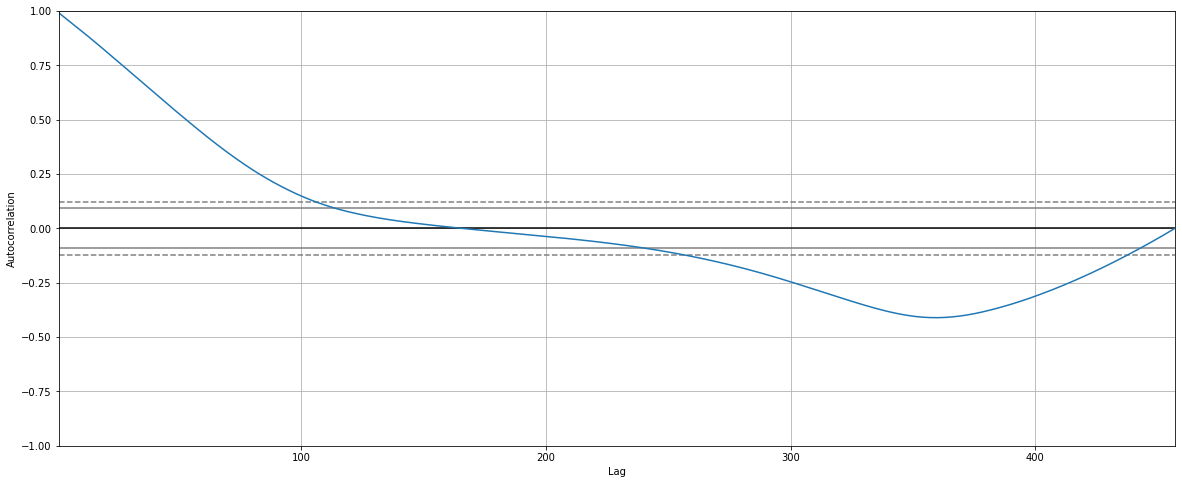

Autocorrelation plot for mean rent price


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


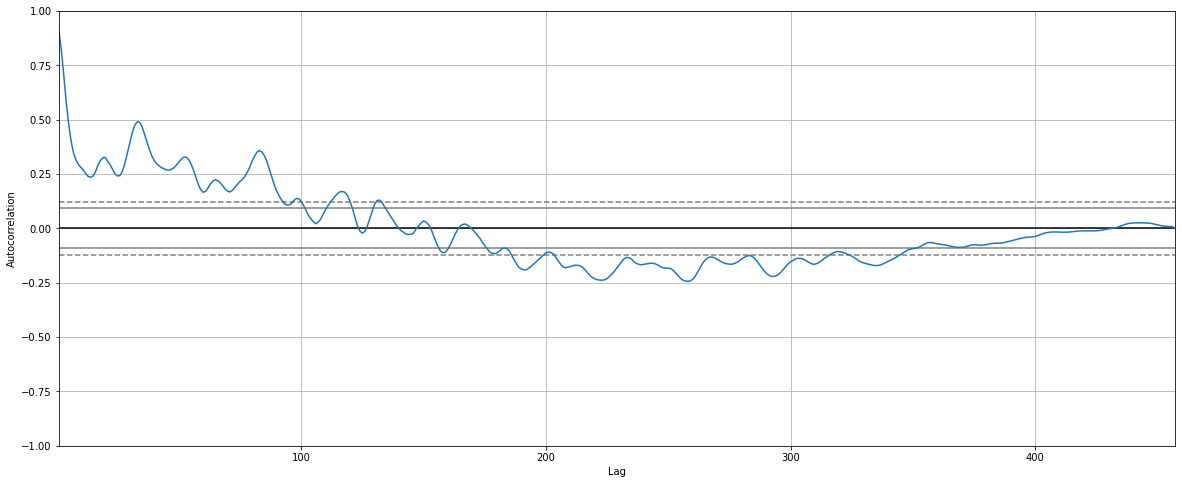

Autocorrelation plot for mean selling price


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


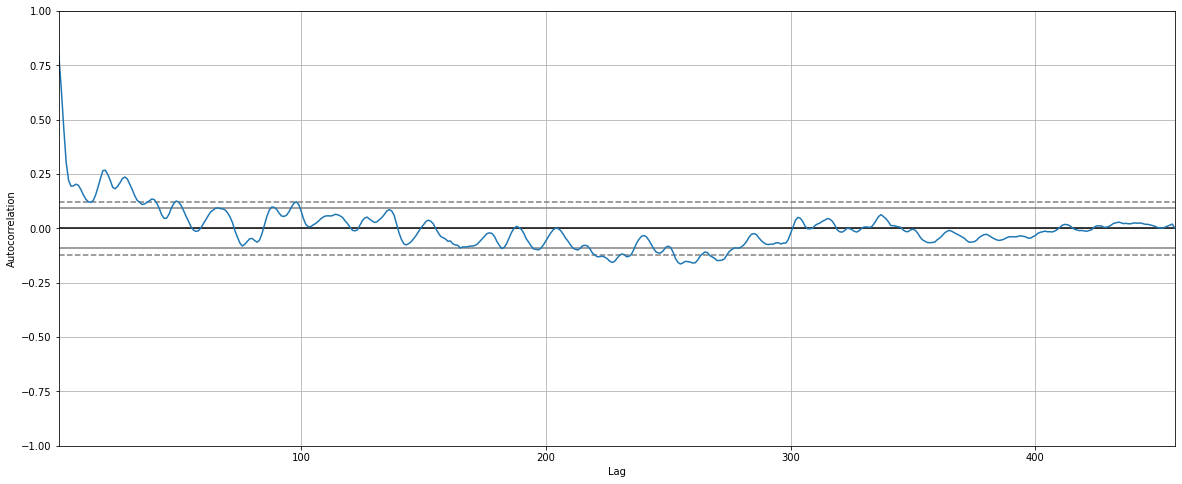

In [3374]:
from pandas.plotting import autocorrelation_plot

print("Autocorrelation plot for covid case rate")
autocorrelation_plot(ts['case_rate_covid'].tolist())
plt.show()

print("Autocorrelation plot for mean rent price")
autocorrelation_plot(ts['mean_rent_price'].tolist())
plt.show()

print("Autocorrelation plot for mean selling price")
autocorrelation_plot(ts['mean_selling_price'].tolist())
plt.show()

# Ploting PACF and ACF
ACF and PACF plots are normally used to determine p and q values for Auto Regressive models.

In [3375]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Case Rate ACF and PACF

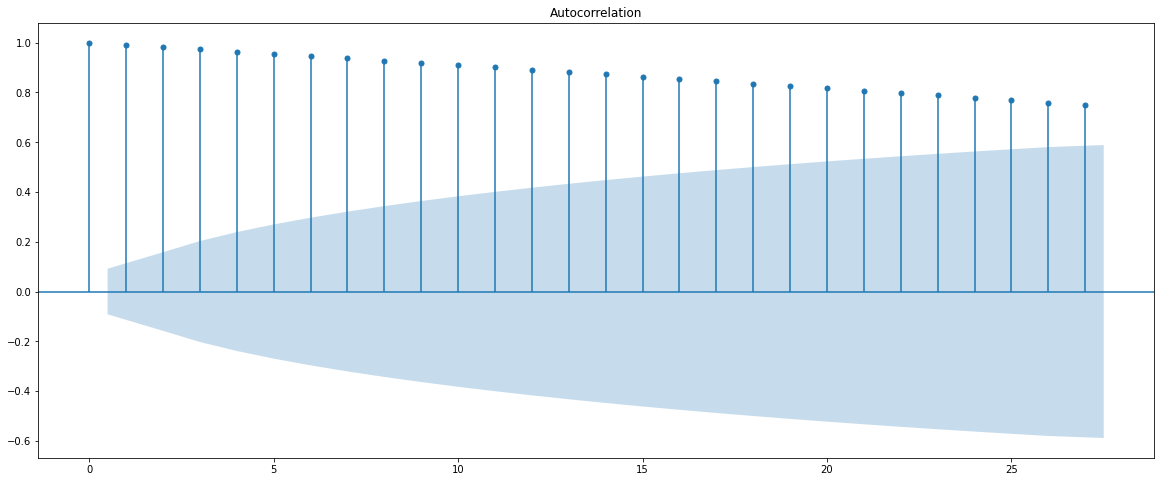

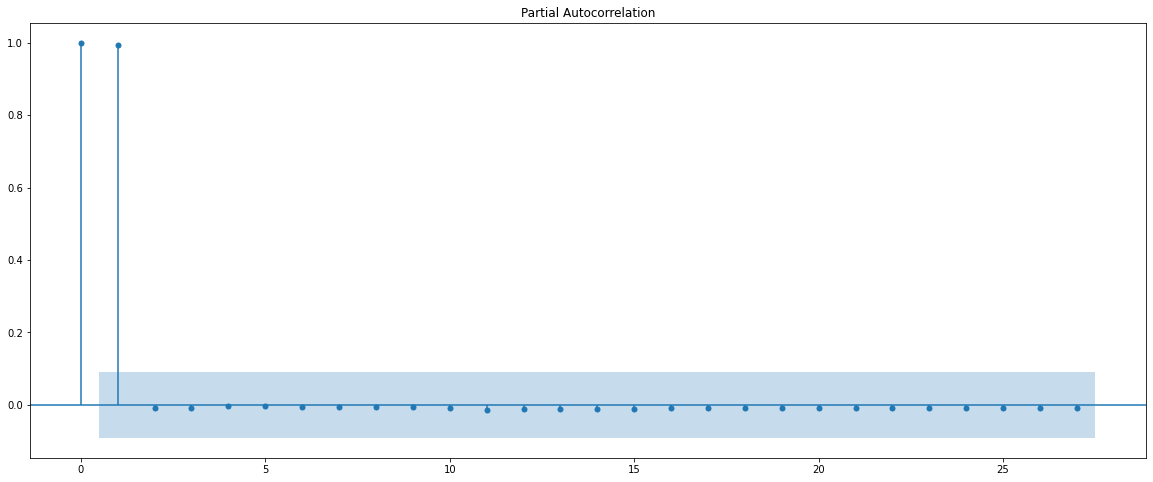

In [3376]:
case_rate = ts[~ts['case_rate_covid'].isna()]['case_rate_covid']
# autocorrelation_plot(case_rate.tolist())
plot_acf(case_rate)
plot_pacf(case_rate)
plt.show()

New Case Rate ACF and PACF

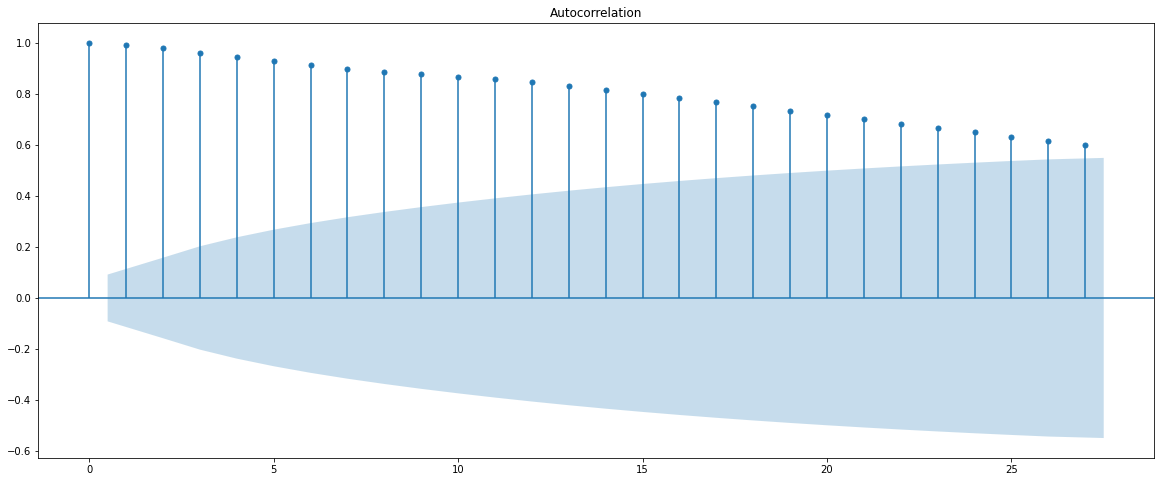

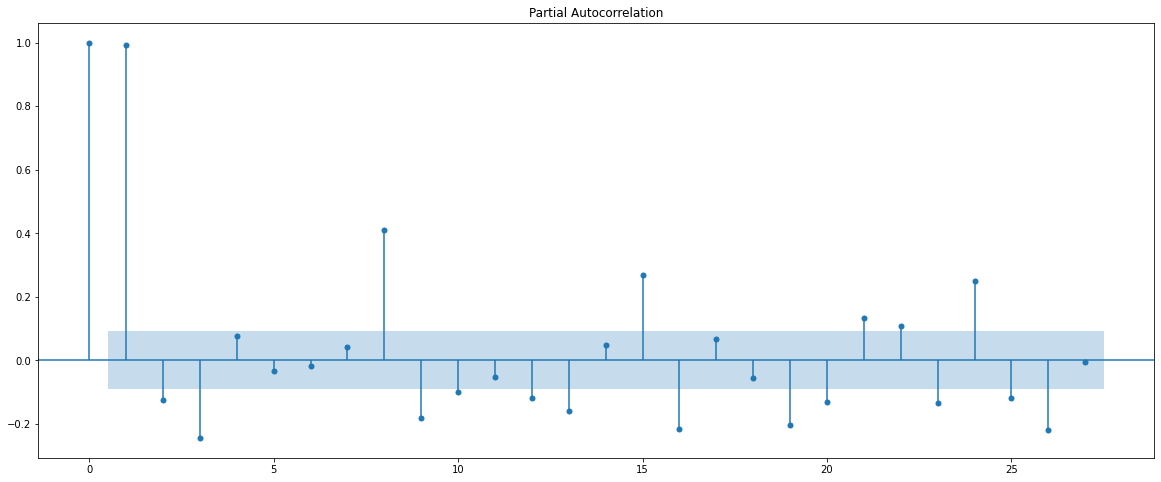

In [3377]:
new_case_rate = ts[~ts['new_case_rate_covid'].isna()]['new_case_rate_covid']
# autocorrelation_plot(new_case_rate.tolist())
plot_acf(new_case_rate)
plot_pacf(new_case_rate)
plt.show()

Mean rent price ACF and PACF

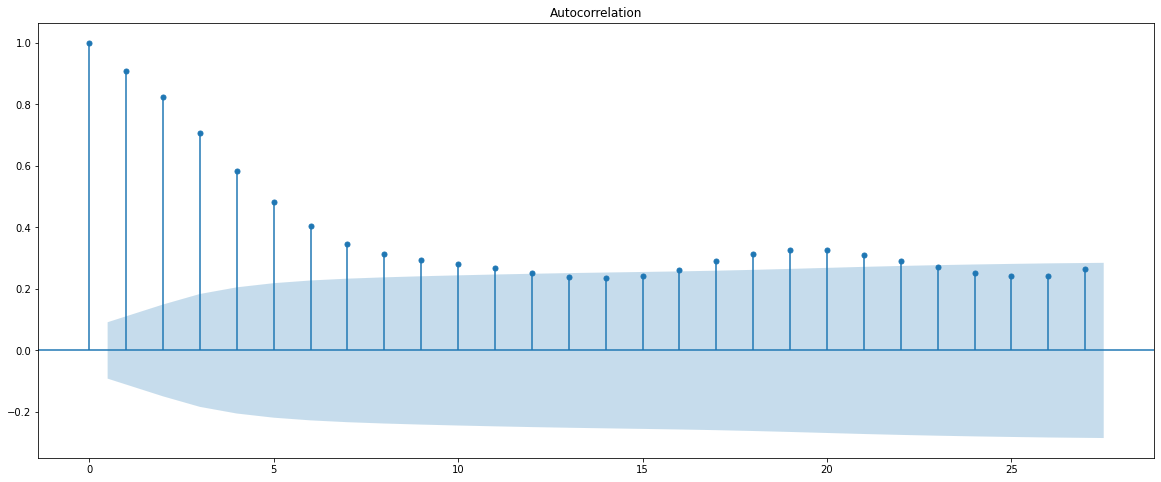

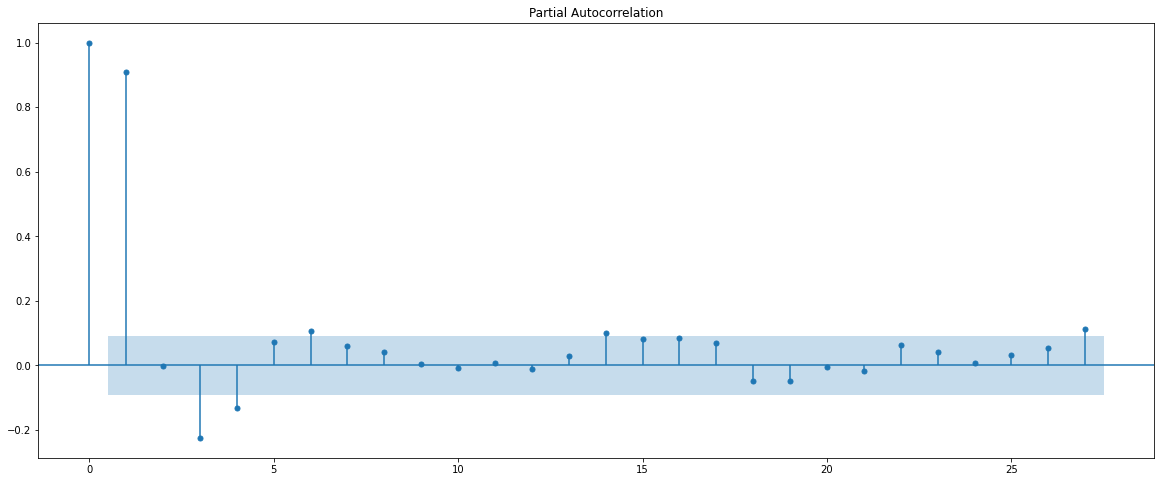

In [3378]:
mean_rent_price = ts[~ts['mean_rent_price'].isna()]['mean_rent_price']
# autocorrelation_plot(mean_price)
plot_acf(mean_rent_price)
plot_pacf(mean_rent_price)
plt.show()

Mean selling price ACF and PACF

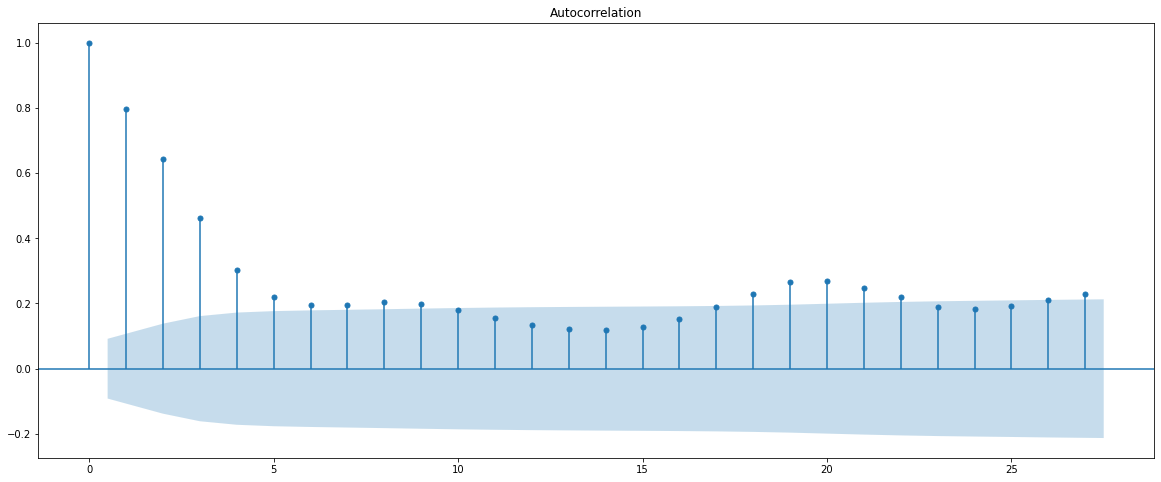

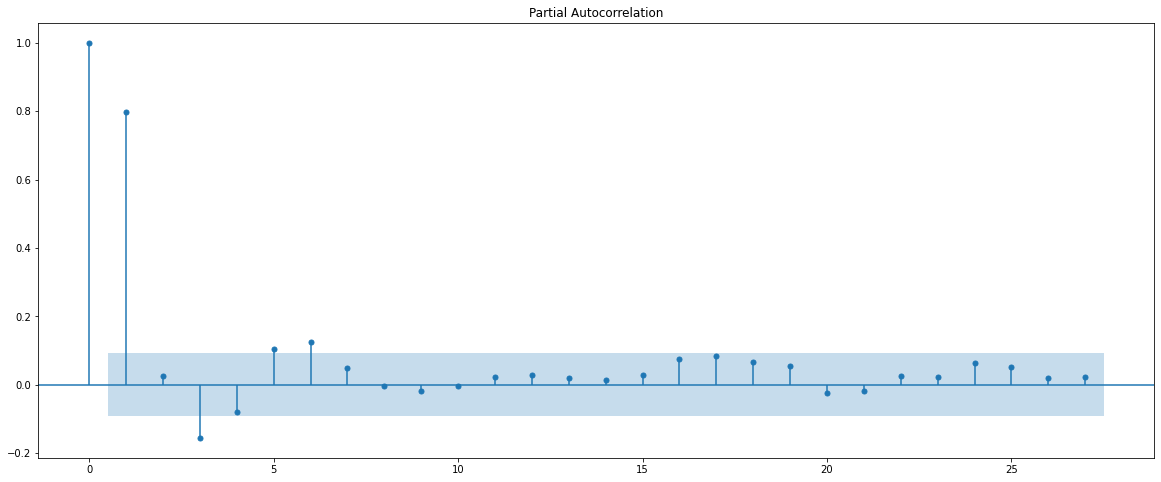

In [3379]:
mean_selling_price = ts[~ts['mean_selling_price'].isna()]['mean_selling_price']
# autocorrelation_plot(mean_selling_price)
plot_acf(mean_selling_price)
plot_pacf(mean_selling_price)
plt.show()


# Lag plots

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

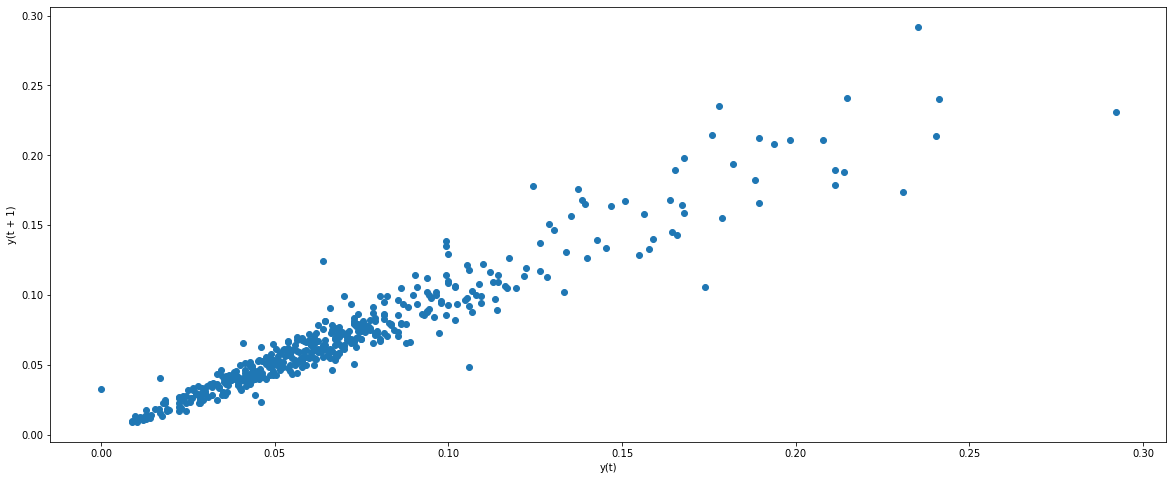

In [3380]:
lag_plot(ts['sales_count'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

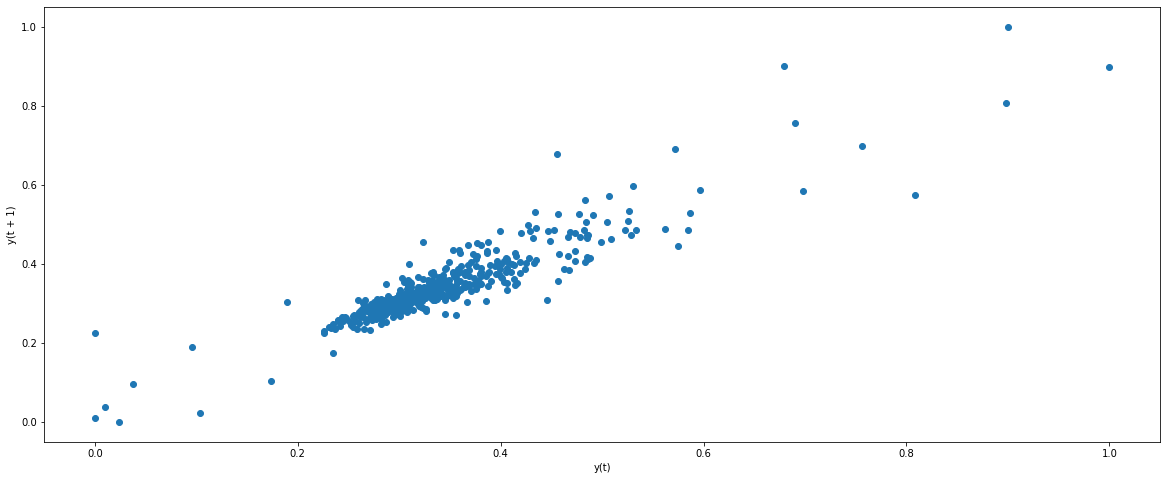

In [3381]:
lag_plot(ts['mean_rent_price_per_sqft'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

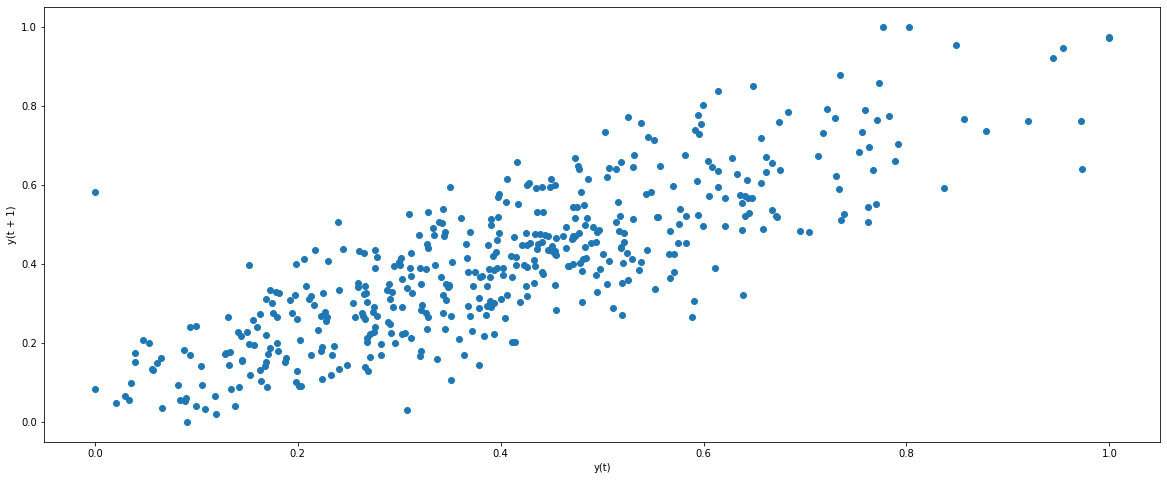

In [3382]:
lag_plot(ts['mean_selling_price_per_sqft'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

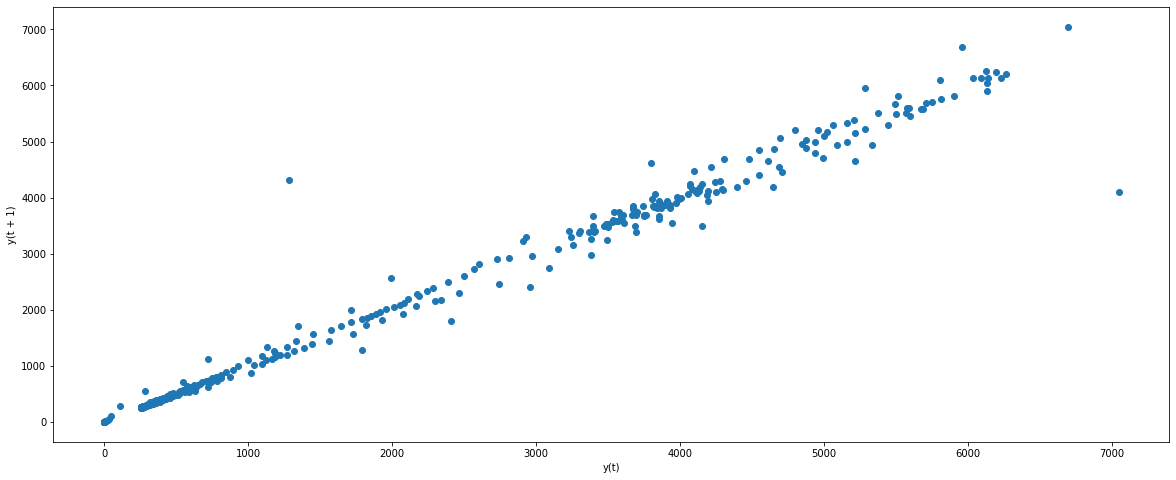

In [3383]:
lag_plot(ts['new_case_count_covid'])

# Cross Correlation

Confidence intervals are drawn as a cone. By default, this is set to a 95 percent confidence interval,
suggesting that correlation values outside of this cone are very likely a correlation.


In [3384]:
# correlation using just ccf and then plotting with custom function
from math import sqrt
from statsmodels.tsa.stattools import ccf

def ccorr_plot(x, y, values=20):
    # this function plots the cross correlation plot with positive and negative lags
    backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1][(-1*(values+1)):]
    forwards = ccf(x,y, adjusted=False)[:(values+1)]
    ccf_output = np.r_[backwards[:-1], forwards]  # we need the [:-1] because we have a duplicate for lag=0
    x_axis = list(range(-1*values, values+1))
    ci = 2*(1/sqrt(len(x)))
    plt.plot(x_axis, [ci]*len(x_axis), color='r', ls="--")
    plt.plot(x_axis, [-1*ci]*len(x_axis), color='r', ls="--")
    plt.stem(x_axis, ccf_output)
    plt.show()

length = 200

## Cross Correlation between renting prices and new cases of covid

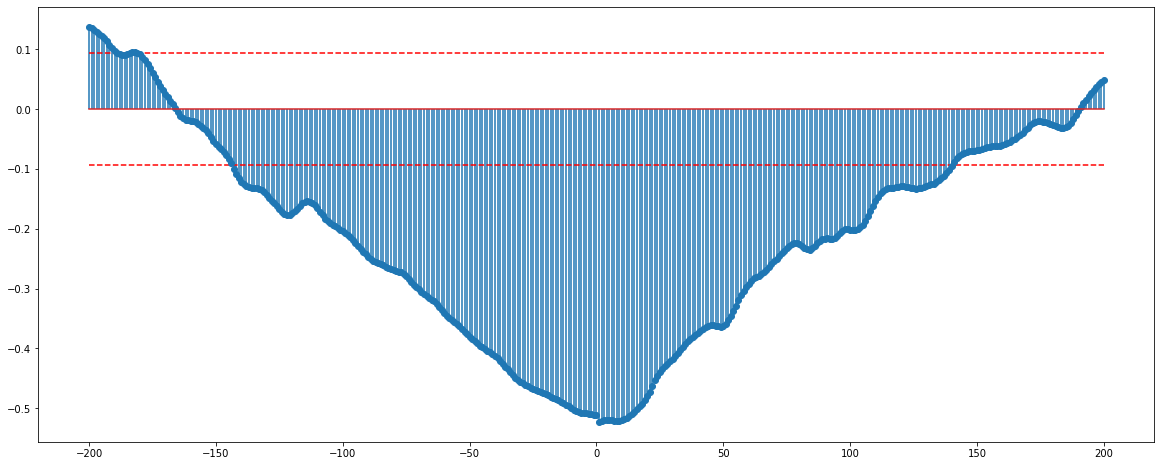

In [3385]:
y = case_rate
x = mean_rent_price[(mean_rent_price.index >= y.index.min()) & (mean_rent_price.index <= y.index.max())]
ccorr_plot(x, y, length)

## Cross Correlation between selling prices and new cases of covid

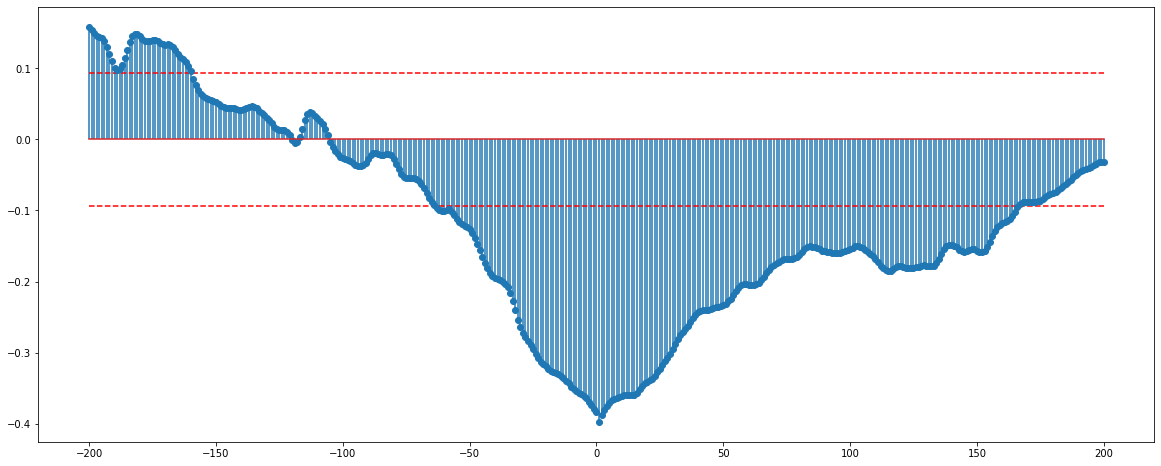

In [3386]:
y = case_rate
x = mean_selling_price[(mean_selling_price.index >= y.index.min()) & (mean_selling_price.index <= y.index.max())]
ccorr_plot(x, y, length)

## Cross Correlation between number of properties sold and new cases of covid

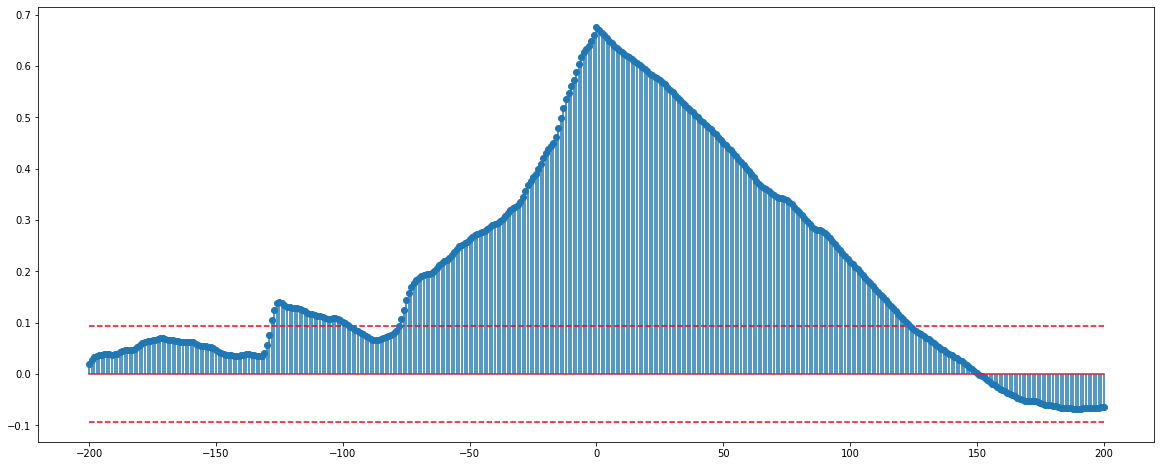

In [3387]:
properties_sold = ts[~ts['sales_count'].isna()]['sales_count']
y = case_rate
x = properties_sold[(properties_sold.index >= y.index.min()) & (properties_sold.index <= y.index.max())]
ccorr_plot(x, y, length)

## Cross Correlation between number of properties sold and covid tests count

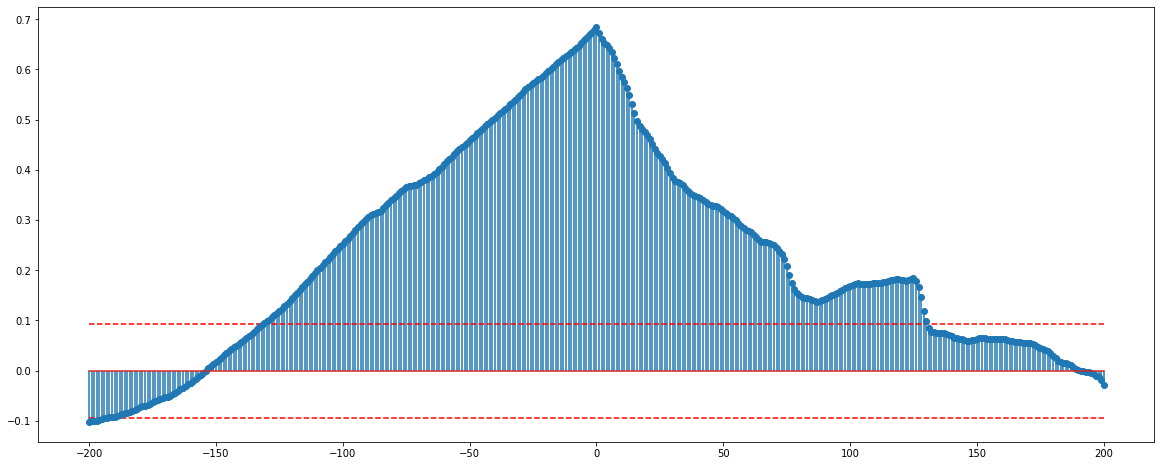

In [3388]:
test_count = ts[~ts['test_count_covid'].isna()]['test_count_covid']
y = properties_sold
x = test_count
ccorr_plot(x, y, length)

# Time Series with lag

A negative value for h (lag) is a correlation between the x-variable at a time before t (the current time) and the y-variable at time t.
if h = -2 then the ccf value would give the correlation between x<sub>t-2</sub> and y<sub>t</sub>.

* if x<sub>t+h</sub> with h __negative__, is a predictor of y<sub>t</sub>, it is said that x __leads__ y.
* if x<sub>t+h</sub> with h __positive__, is a predictor of y<sub>t</sub>, it is said that x __lags__ y.

In some problems, the goal may be to identify which variable is leading and which is lagging.
In many problems we consider, though, we’ll examine the x-variable(s) to be a leading variable
of the y-variable because we will want to use values of the x-variable to predict future values of y.

We think in this case because our x is real estate and our y is covid and h is negative we can say that real estate leads covid in some weird way.
This is not what we wanted to show but it is the result we are getting.

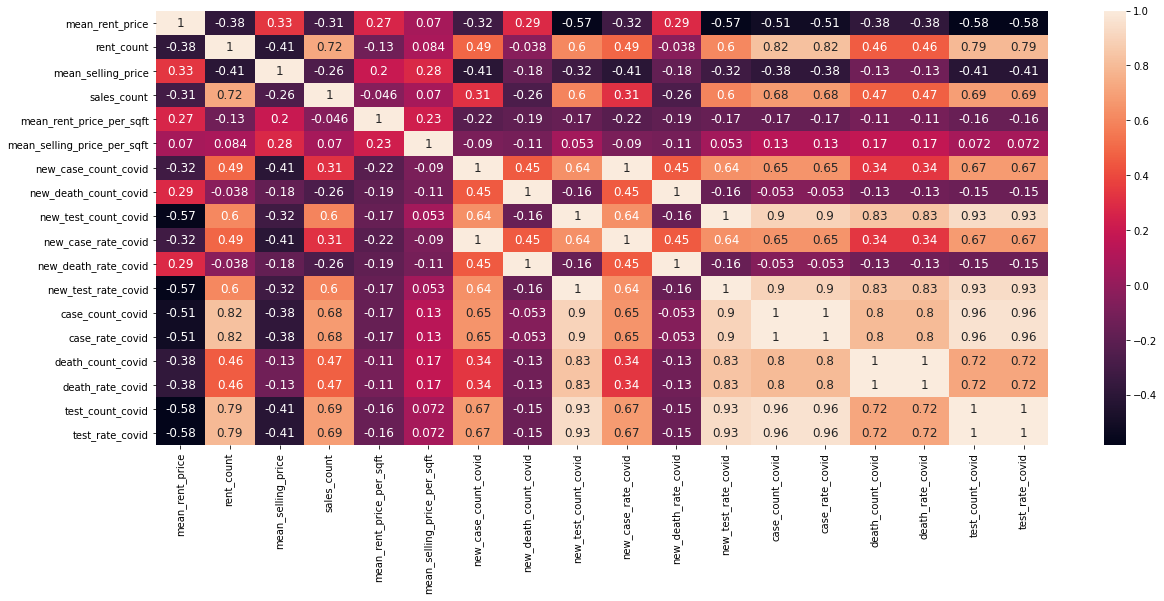

In [3389]:
import seaborn as sns
corr = ts.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
# heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()



There seems to be no seasonality in the real estate data but there seems to be seasons in the case-rate of covid

# Stationary Behavior
Stationary data means that the statistical properties of the particular process (mean and variance) do not vary with time.
Most TS models work on the assumption that the TS is stationary.

To test for stationarity we can use the Dickey-Fuller test. In this test the null hypothesis is that the Time series is non-stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that
the series is stationary.

# Stationarity checks

Exploratory data analysis is the process of using a graphical representation to discover and investigate patterns within data.
Kernel density estimation (KDE) is a nonparametric way to estimate the probability density function (PDF) of a random variable

# ADF test

The ADF test is fundamentally a statistical significance test. That means there is a hypothesis
testing involved with a null and alternate hypothesis and as a result a test statistic is
computed and p-values get reported. From the statistic test and the p-values , we can make an
inference as to whether a given time series is stationary or not.
A key point to remember here is: Since the null hypothesis assumes the presence of unit root,
that is α=1, the p-value obtained should be less than the significance level (say 0.05 or 0.01)
in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

In [3390]:
from statsmodels.tsa.stattools import adfuller

#Here is the ADF test function to check for stationary data:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput)
        if dftest[1] <= 0.05:
             print("Conclusion:====>")
             print("Reject the null hypothesis")
             print("Data is stationary")
        else:
             print("Conclusion:====>")
             print("Fail to reject the null hypothesis")
             print("Data is non-stationary")

In [3391]:
print("COVID Results of Dicke-Fuller Test:\n")
Augmented_Dickey_Fuller_Test_func(case_rate, 'Case Rate')

COVID Results of Dicke-Fuller Test:

Results of Dickey-Fuller Test for column: Case Rate
Test Statistic                   1.584526
p-value                          0.997810
No Lags Used                    15.000000
Number of Observations Used    441.000000
Critical Value (1%)             -3.445266
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                   1.584526
p-value                          0.997810
No Lags Used                    15.000000
Number of Observations Used    441.000000
Critical Value (1%)             -3.445266
Critical Value (5%)             -2.868116
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                   1.584526
p-value                          0.997810
No Lags Used                    15.000000
Number of Observations Used    441.000000
Critical Value (1%)             -3.445266
Critical Value (5%)             -2.868116
Critical Value (1

In [3392]:
print("COVID Results (case count) of Dicke-Fuller Test:\n")
Augmented_Dickey_Fuller_Test_func(ts['case_count_covid'], 'Case count')

COVID Results (case count) of Dicke-Fuller Test:

Results of Dickey-Fuller Test for column: Case count
Test Statistic                   1.742294
p-value                          0.998227
No Lags Used                    16.000000
Number of Observations Used    440.000000
Critical Value (1%)             -3.445300
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                   1.742294
p-value                          0.998227
No Lags Used                    16.000000
Number of Observations Used    440.000000
Critical Value (1%)             -3.445300
Critical Value (5%)             -2.868131
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                   1.742294
p-value                          0.998227
No Lags Used                    16.000000
Number of Observations Used    440.000000
Critical Value (1%)             -3.445300
Critical Value (5%)             -2.868131
Cri

It seems that we can't reject the null hypothesis in the case of COVID case-rate

In [3393]:
print("Rent Results of Dicke-Fuller Test:")
Augmented_Dickey_Fuller_Test_func(mean_rent_price, "Rent")

Rent Results of Dicke-Fuller Test:
Results of Dickey-Fuller Test for column: Rent
Test Statistic                  -2.758000
p-value                          0.064528
No Lags Used                    18.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                  -2.758000
p-value                          0.064528
No Lags Used                    18.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
Critical Value (5%)             -2.868161
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                  -2.758000
p-value                          0.064528
No Lags Used                    18.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
Critical Value (5%)             -2.868161
Critical Value (10%)    

It seems that we can't reject the null hypothesis in the rent time series

In [3394]:
print("Sales Results of Dicke-Fuller Test:")
Augmented_Dickey_Fuller_Test_func(mean_selling_price, "Sales")

Sales Results of Dicke-Fuller Test:
Results of Dickey-Fuller Test for column: Sales
Test Statistic                  -2.886407
p-value                          0.046952
No Lags Used                    18.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                  -2.886407
p-value                          0.046952
No Lags Used                    18.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
Critical Value (5%)             -2.868161
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                  -2.886407
p-value                          0.046952
No Lags Used                    18.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
Critical Value (5%)             -2.868161
Critical Value (10%)            -2.570297
dtyp

In the case of mean rent prices it seems that we can reject the null hypothesis and say that the time series is stationary

# Making COVID TS stationary
We could use time series decomposition or we could apply differencing to the time series.

### Using seasonal decomposition to remove seasonality and trend from Covid rates TS

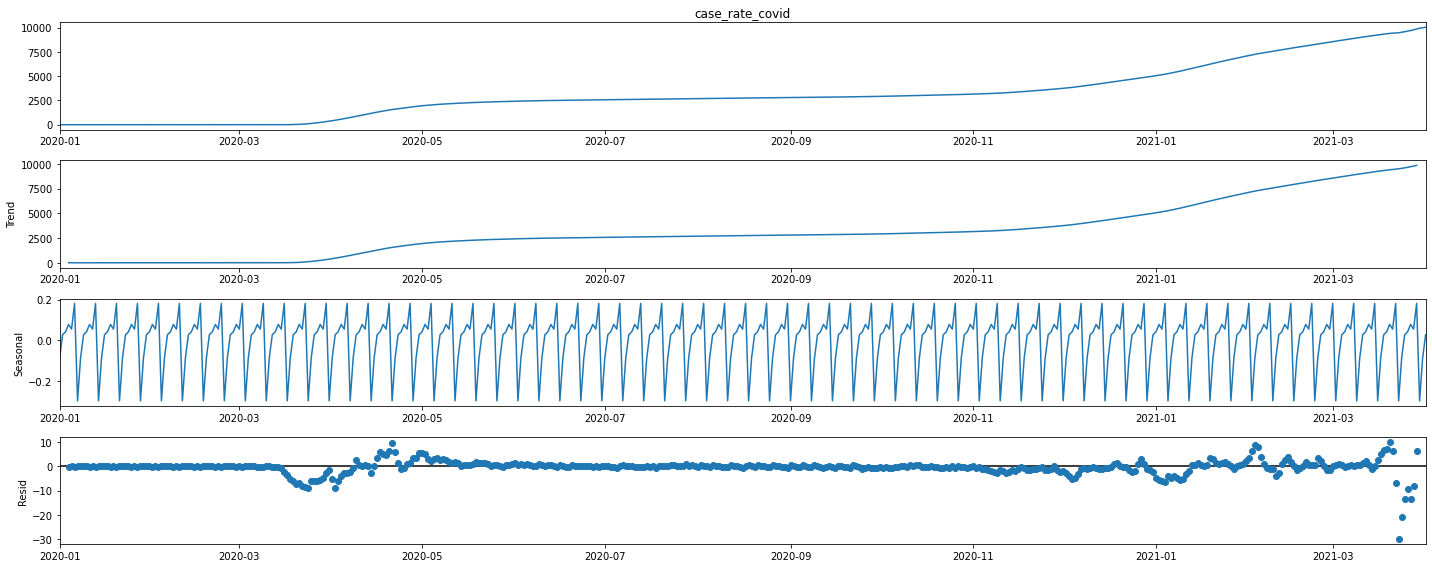

In [3395]:
case_rate_covid = ts['case_rate_covid'][~ts['case_rate_covid'].isna()]
case_rate_decomp = seasonal_decompose(case_rate_covid, model='additive')
case_rate_decomp.plot()
plt.show()

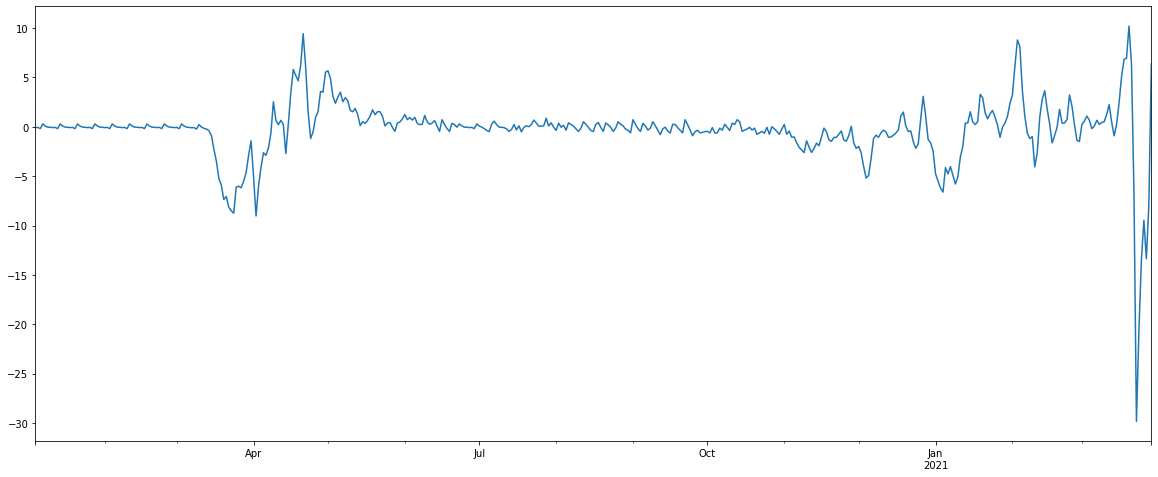

Results of Dicke-Fuller Test on residual case rate:
Results of Dickey-Fuller Test for column: Case rate Residual
Test Statistic                  -3.697264
p-value                          0.004152
No Lags Used                    13.000000
Number of Observations Used    437.000000
Critical Value (1%)             -3.445403
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                  -3.697264
p-value                          0.004152
No Lags Used                    13.000000
Number of Observations Used    437.000000
Critical Value (1%)             -3.445403
Critical Value (5%)             -2.868177
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                  -3.697264
p-value                          0.004152
No Lags Used                    13.000000
Number of Observations Used    437.000000
Critical Value (1%)             -3.445403
Critical Value (5%)             -2.868177
Critical Value (1

In [3396]:
case_rate_resid = case_rate_decomp.resid
case_rate_resid = case_rate_resid[~case_rate_resid.isna()]
case_rate_resid.plot()
plt.show()

print("Results of Dicke-Fuller Test on residual case rate:")
Augmented_Dickey_Fuller_Test_func(case_rate_resid, 'Case rate Residual')


Seasonal decomposition worked for removing trend and seasonality and making the series stationary.

# Using KPSS to test for Stationarity.

In [3397]:
X1 = np.array(ts['case_rate_covid'])
X1 = X1[~np.isnan(X1)]

X2 = np.array(case_rate_resid)
X2 = X2[~np.isnan(X2)]

## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

print("Original Case Rate Time Series\n")
kpss_test(X1)
print("\n")
print("Residual of Case Rate Time Series\n")
kpss_test(X2)

Original Case Rate Time Series

KPSS Statistic: 2.1337251407801516
p-value: 0.01
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


Residual of Case Rate Time Series

KPSS Statistic: 0.1026735350940585
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values

# Making Rent TS stationary

### Using seasonal decomposition to remove seasonality and trend from rent TS

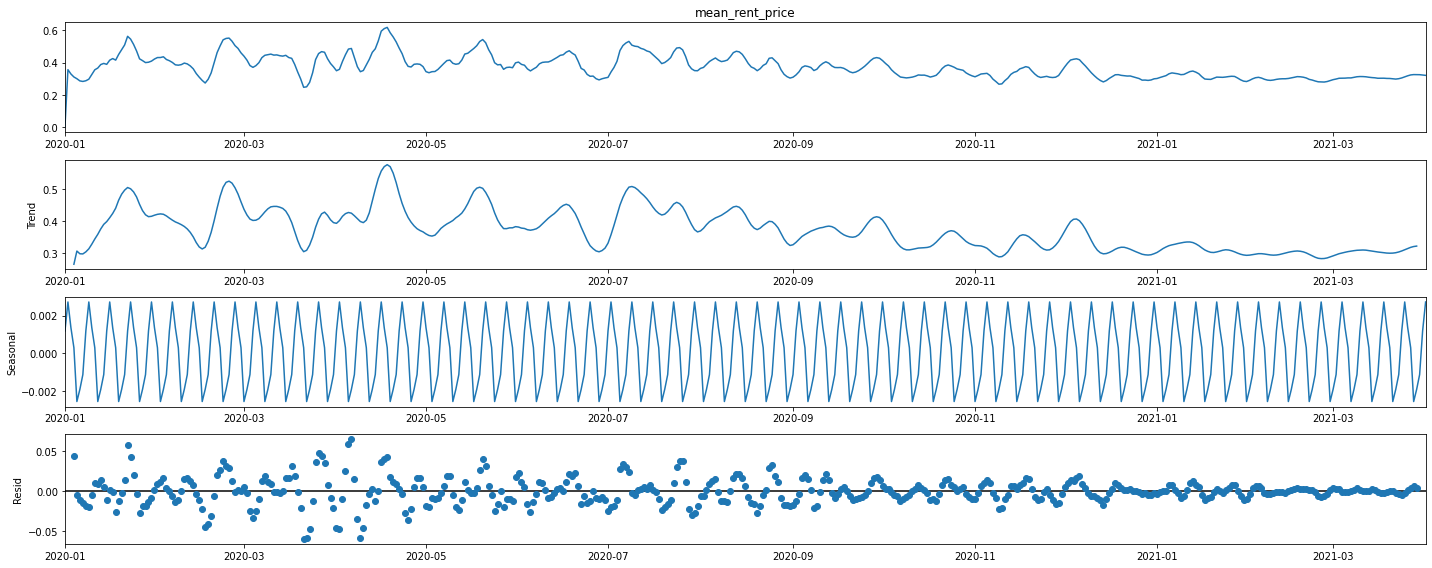

In [3398]:
rent = ts['mean_rent_price'][~ts['mean_rent_price'].isna()]
rent_decomp = seasonal_decompose(rent, model='additive')
rent_decomp.plot()
plt.show()

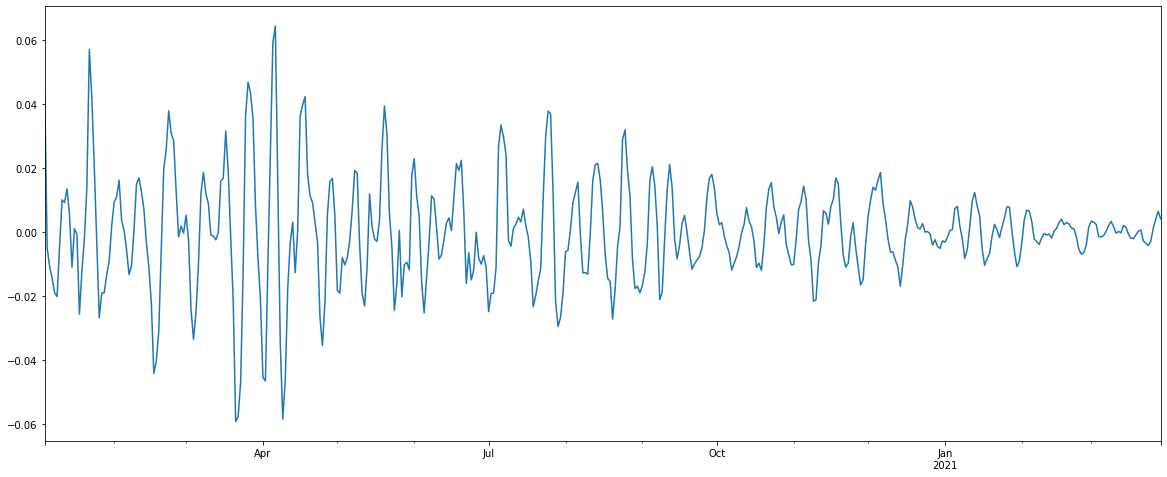

Results of Dicke-Fuller Test on residual rent prices:
Results of Dickey-Fuller Test for column: Rent
Test Statistic                -9.480615e+00
p-value                        3.881900e-16
No Lags Used                   1.800000e+01
Number of Observations Used    4.320000e+02
Critical Value (1%)           -3.445578e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                -9.480615e+00
p-value                        3.881900e-16
No Lags Used                   1.800000e+01
Number of Observations Used    4.320000e+02
Critical Value (1%)           -3.445578e+00
Critical Value (5%)           -2.868254e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                -9.480615e+00
p-value                        3.881900e-16
No Lags Used                   1.800000e+01
Number of Observations Used    4.320000e+02
Critical Value (1%)           -3.445578e+00
Critical Value (5%)           -2.868254

In [3399]:
rent_resid = rent_decomp.resid
rent_resid = rent_resid[~rent_resid.isna()]
rent_resid.plot()
plt.show()

print("Results of Dicke-Fuller Test on residual rent prices:")
Augmented_Dickey_Fuller_Test_func(rent_resid, 'Rent')

Seasonal decomposition worked for removing trend and seasonality and making the series stationary.


# Using KPSS to test for Stationarity.

In [3400]:
X1 = np.array(ts['mean_rent_price'])
X1 = X1[~np.isnan(X1)]

X2 = np.array(rent_resid)
X2 = X2[~np.isnan(X2)]

## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

print("Original Rent Price Time Series\n")
kpss_test(X1)
print("\n")
print("Residual of Rent Price Time Series\n")
kpss_test(X2)

Original Rent Price Time Series

KPSS Statistic: 1.5829467686303345
p-value: 0.01
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


Residual of Rent Price Time Series

KPSS Statistic: 0.029592868889569784
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values

In [3401]:
if stationary_method == 'resid':
    ts['case_rate_covid'] = case_rate_resid
    ts['mean_rent_price'] = rent_resid
    ts.fillna(0, inplace=True)

# Using Differencing

First we use differencing to make the case rate time series stationary.

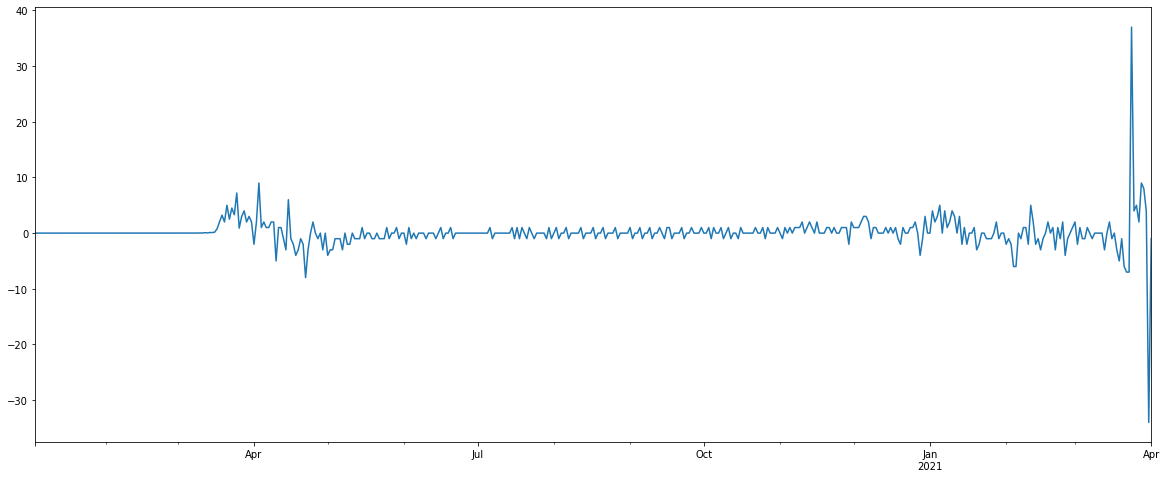

Results of ADF on differenced covid case rate:
Results of Dickey-Fuller Test for column: Diff Covid Case Rate
Test Statistic                  -4.293209
p-value                          0.000456
No Lags Used                    13.000000
Number of Observations Used    441.000000
Critical Value (1%)             -3.445266
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                  -4.293209
p-value                          0.000456
No Lags Used                    13.000000
Number of Observations Used    441.000000
Critical Value (1%)             -3.445266
Critical Value (5%)             -2.868116
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                  -4.293209
p-value                          0.000456
No Lags Used                    13.000000
Number of Observations Used    441.000000
Critical Value (1%)             -3.445266
Critical Value (5%)             -2.868116
Critical Value (10%)

In [3402]:
case_rate_diff = ts['case_rate_covid'].diff().diff()  # we tried using a single diff but it did not make the data stationary.
case_rate_diff = case_rate_diff[~case_rate_diff.isna()]
case_rate_diff.plot()
plt.show()

print("Results of ADF on differenced covid case rate:")
Augmented_Dickey_Fuller_Test_func(case_rate_diff, 'Diff Covid Case Rate')

Now we use differencing on the Rent price time series.

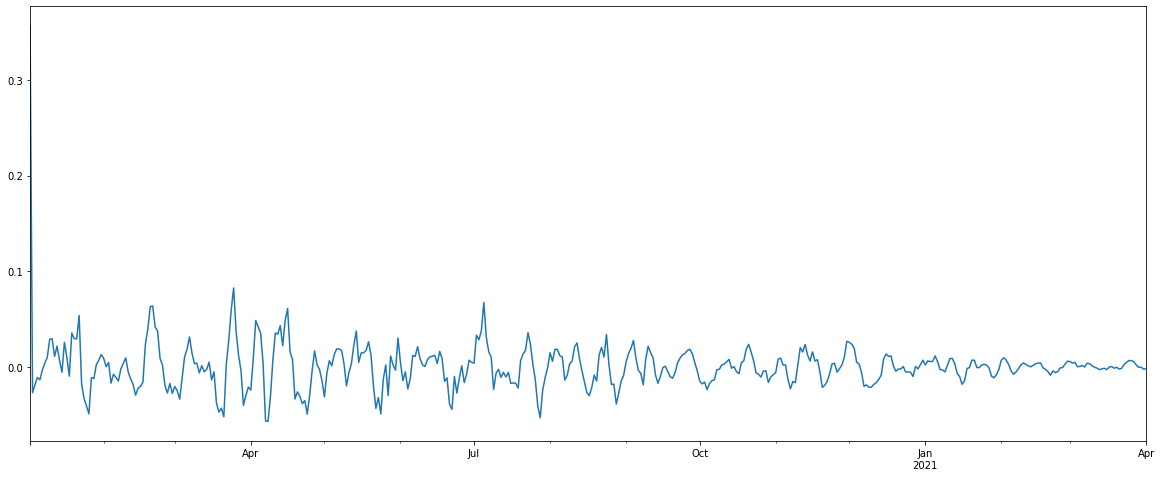

Results of ADF on differenced rent prices:
Results of Dickey-Fuller Test for column: Diff Rent Prices
Test Statistic                -6.447171e+00
p-value                        1.555490e-08
No Lags Used                   1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.445368e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                -6.447171e+00
p-value                        1.555490e-08
No Lags Used                   1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.445368e+00
Critical Value (5%)           -2.868161e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary
Test Statistic                -6.447171e+00
p-value                        1.555490e-08
No Lags Used                   1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.445368e+00
Critical Value (5%)           -2.86816

In [3403]:
rent_diff = ts['mean_rent_price'].diff()
rent_diff = rent_diff[~rent_diff.isna()]
rent_diff.plot()
plt.show()

print("Results of ADF on differenced rent prices:")
Augmented_Dickey_Fuller_Test_func(rent_diff, 'Diff Rent Prices')

In [3404]:
# we could test every column in our time series. Only the covid ts, the rent and the counts are not stationary
# for col in ts.columns:
#     Augmented_Dickey_Fuller_Test_func(ts[col], col)

In [3405]:
if stationary_method == 'diff':
    ts['case_rate_covid'] = case_rate_diff
    ts['case_count_covid'] = ts['case_count_covid'].diff().diff()
    ts['mean_rent_price'] = rent_diff
    ts.fillna(0, inplace=True)

### Correlation between selling price/sqft and the residual of covid cases rate

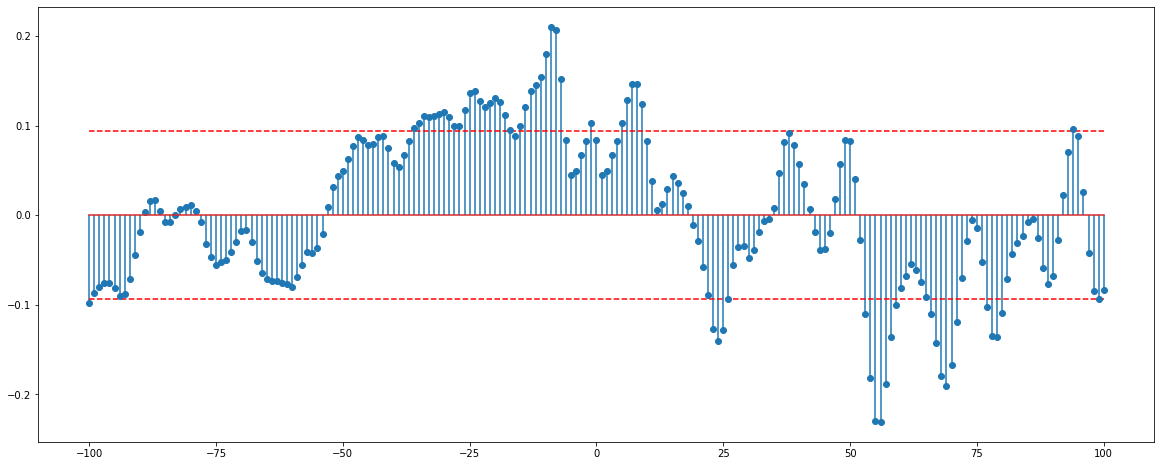

In [3406]:
mean_sqft_selling = ts['mean_selling_price_per_sqft']
mean_sqft_selling = mean_sqft_selling[~mean_sqft_selling.isna()]
ccorr_plot(case_rate_resid, mean_sqft_selling, 100)

# Univariate Modeling on Rental Prices

## ARIMA
In these scenarios, auto-regressive models can be very useful as these models adjust
immediately using the prior lag values by taking advantage of inherent serial correlation
between observations.

ARIMA uses information obtained from the variable itself to forecast its trend, and the variable is regressed on its own past values
A nonseasonal ARIMA model is called an ARIMA(p,d,q) model, where:
• p is the number of autoregressive terms.
• d is the number of nonseasonal differences needed for stationarity.
• q is the number of lagged forecast errors in the prediction equation.

### Using pmdarima

https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0

Pmdarima‘s auto_arima function is extremely useful when building an ARIMA model as it helps us identify the most optimal p,d,q parameters and return a fitted ARIMA model.

Forecasting horizon: 30 hours
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-1581.970, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-1756.593, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-1607.620, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-1843.005, Time=0.78 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=-1856.024, Time=0.94 sec
 ARIMA(1,1,0)(4,1,0)[4]             : AIC=-1932.970, Time=1.89 sec
 ARIMA(1,1,0)(5,1,0)[4]             : AIC=-1961.082, Time=1.61 sec
 ARIMA(1,1,0)(6,1,0)[4]             : AIC=-1968.290, Time=1.62 sec
 ARIMA(1,1,0)(7,1,0)[4]             : AIC=-1980.417, Time=2.87 sec
 ARIMA(1,1,0)(8,1,0)[4]             : AIC=-1988.331, Time=8.30 sec
 ARIMA(1,1,0)(9,1,0)[4]             : AIC=-1992.820, Time=9.21 sec
 ARIMA(1,1,0)(10,1,0)[4]             : AIC=-2001.648, Time=12.71 sec
 ARIMA(1,1,0)(10,1,1)[4]             : AIC=-1997.224, Time=1

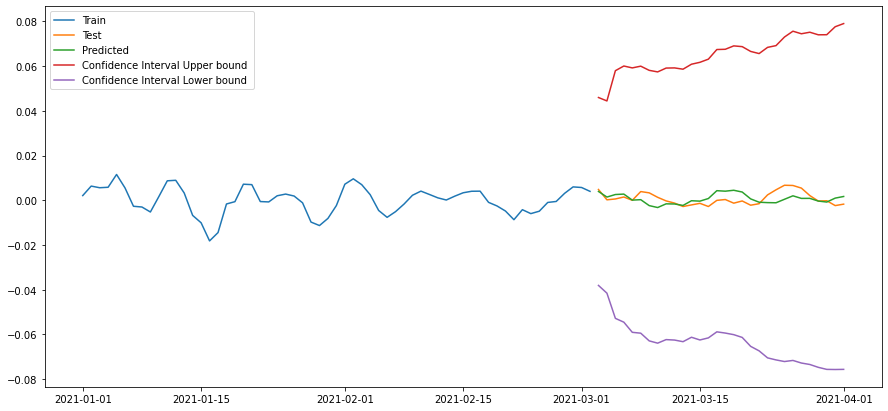

In [3407]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
# ts.fillna(0, inplace=True)
#
HORIZON = 30
print('Forecasting horizon:', HORIZON, 'hours')

train, test = ts['mean_rent_price'][0:-HORIZON], ts['mean_rent_price'][-HORIZON:]
model = pm.auto_arima(train, start_p=0,d=1,start_q=0,
                      max_p=10,max_d=10,max_q=10, start_P=0,
                      D=1, start_Q=0, max_P=10,max_D=10,
                      max_Q=10, m=4, seasonal=True,
                      error_action='warn',trace=True,
                      supress_warnings=True,stepwise=True,
                      random_state=20,n_fits=50)

print(model.summary())

forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])
df_conf = pd.DataFrame(conf_int,columns= [ 'Lower_bound', 'Upper_bound'])

df_conf["new_index"] = test.index
df_conf = df_conf.set_index("new_index")
forecast["new_index"] = test.index
forecast = forecast.set_index("new_index")

plt.rcParams["figure.figsize"] = [15,7]
plt.plot(train['2021':], label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

# Univariate Modeling on Selling Prices

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-1419.680, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-1697.399, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-1537.593, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-1736.929, Time=0.72 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=-1760.774, Time=2.34 sec
 ARIMA(1,1,0)(4,1,0)[4]             : AIC=-1790.374, Time=1.75 sec
 ARIMA(1,1,0)(5,1,0)[4]             : AIC=-1798.784, Time=2.34 sec
 ARIMA(1,1,0)(6,1,0)[4]             : AIC=-1805.678, Time=1.98 sec
 ARIMA(1,1,0)(7,1,0)[4]             : AIC=-1813.566, Time=3.11 sec
 ARIMA(1,1,0)(8,1,0)[4]             : AIC=-1812.863, Time=2.79 sec
 ARIMA(1,1,0)(7,1,1)[4]             : AIC=-1814.888, Time=6.10 sec
 ARIMA(1,1,0)(6,1,1)[4]             : AIC=-1802.748, Time=1.69 sec
 ARIMA(1,1,0)(8,1,1)[4]             : AIC=-1814.728, Time=10.85 sec
 ARIMA(1,1,0)(7,1,2)[4] 

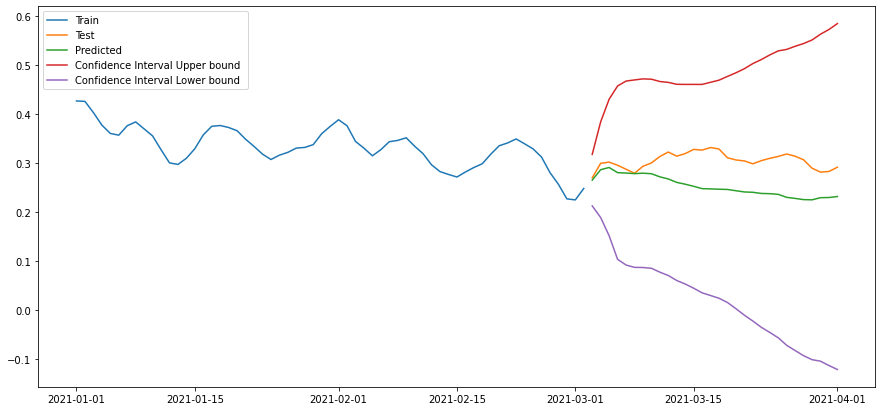

In [3408]:
train, test = ts['mean_selling_price'][0:-HORIZON], ts['mean_selling_price'][-HORIZON:]
model = pm.auto_arima(train, start_p=0,d=1,start_q=0,
                      max_p=10,max_d=10,max_q=10, start_P=0,
                      D=1, start_Q=0, max_P=10,max_D=10,
                      max_Q=10, m=4, seasonal=True,
                      error_action='warn',trace=True,
                      supress_warnings=True,stepwise=True,
                      random_state=20,n_fits=50)

print(model.summary())

forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])
df_conf = pd.DataFrame(conf_int,columns= [ 'Lower_bound', 'Upper_bound'])

df_conf["new_index"] = test.index
df_conf = df_conf.set_index("new_index")
forecast["new_index"] = test.index
forecast = forecast.set_index("new_index")

plt.rcParams["figure.figsize"] = [15,7]
plt.plot(train['2021':], label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

# Univariate Modeling on Covid Case rate

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=1982.055, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=1775.288, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=1869.780, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=1689.417, Time=0.12 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=1683.280, Time=0.18 sec
 ARIMA(1,1,0)(4,1,0)[4]             : AIC=1662.175, Time=0.29 sec
 ARIMA(1,1,0)(5,1,0)[4]             : AIC=1661.446, Time=0.40 sec
 ARIMA(1,1,0)(6,1,0)[4]             : AIC=1661.095, Time=0.58 sec
 ARIMA(1,1,0)(7,1,0)[4]             : AIC=1641.084, Time=0.78 sec
 ARIMA(1,1,0)(8,1,0)[4]             : AIC=1634.470, Time=1.19 sec
 ARIMA(1,1,0)(9,1,0)[4]             : AIC=1626.718, Time=1.50 sec
 ARIMA(1,1,0)(10,1,0)[4]             : AIC=1623.251, Time=2.13 sec
 ARIMA(1,1,0)(10,1,1)[4]             : AIC=1607.726, Time=7.17 sec
 ARIMA(1,1,0)(9,1,1)[4]             

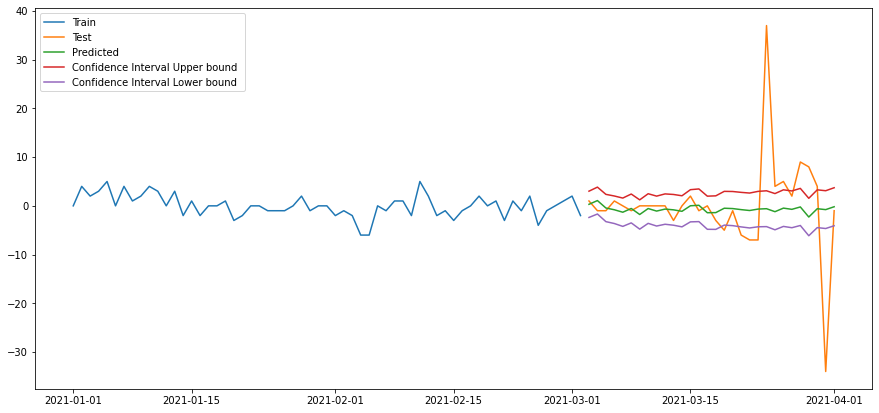

In [3409]:
import pmdarima as pm
train, test = ts['case_rate_covid'][0:-HORIZON], ts['case_rate_covid'][-HORIZON:]
# model = pm.auto_arima(train, start_p=0, start_q=0,
#                       max_P=20,max_D=20,max_Q=20, D=1, d=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       seasonal=False,   # No Seasonality
#                       m=12,
#                       start_P=0,
#                       start_Q=0,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True,
#                       stepwise=True)
model = pm.auto_arima(train, start_p=0,d=1,start_q=0,
                      max_p=10,max_d=10,max_q=10, start_P=0,
                      D=1, start_Q=0, max_P=10,max_D=10,
                      max_Q=10, m=4, seasonal=True,
                      error_action='warn',trace=True,
                      supress_warnings=True,stepwise=True,
                      random_state=20,n_fits=50)

print(model.summary())

forecast, conf_int = model.predict(n_periods=30, return_conf_int=True) 
forecast = pd.DataFrame(forecast,columns=['close_pred'])
df_conf = pd.DataFrame(conf_int,columns= ['Lower_bound', 'Upper_bound'])

df_conf["new_index"] = test.index
df_conf = df_conf.set_index("new_index")
forecast["new_index"] = test.index
forecast = forecast.set_index("new_index")

# get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15,7]
plt.plot(train['2021':], label='Train ') 
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

In [3410]:
# results_AR = model.fit(df['resid'], disp=1)
# df.plot()
# # plt.plot(results_AR.predict(), color='red')
# # results_AR.plot_predict()
# plt.show()

In [3411]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

data = ts[['mean_selling_price', 'mean_rent_price', 'mean_rent_price_per_sqft', 'case_rate_covid']]
data.fillna(data.min(), inplace=True)


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Granger causality analysis rests on the assumption that if a variable X causes Y then changes in X will systematically occur
before changes in Y. We will thus find that the lagged values of X will exhibit a statistically significant correlation with Y.
Correlation however does not prove causation.

Take granger's causality between every pair of columns in the data

In [3412]:
# df = data
# # import for Granger's Causality Test
# granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'median_price_per_sqft']], maxlag=2, verbose=True)
# granger_test

In [3413]:
# granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'new_case_rate_covid']], maxlag=2, verbose=True)
# granger_test

In [3414]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(cdf_diff):
    res = coint_johansen(cdf_diff,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name > Test Stat > C(95%) => Signif\n', '--'*20)
    for col, trace, cvt in zip(cdf_diff.columns, traces, cvts):
          print(adjust(col), '> ', adjust(round(trace,2), 9),">", adjust(cvt, 8), ' => ' , trace > cvt)

cointegration_test(ts[['mean_rent_price', 'case_count_covid']])


Column Name > Test Stat > C(95%) => Signif
 ----------------------------------------
mean_rent_price >  163.29    > 12.3212   =>  True
case_count_covid >  48.41     > 4.1296    =>  True


# Multivariate Modeling with VAR model

In [3415]:
train = ts[['case_count_covid', 'mean_rent_price']][0:-HORIZON]
test = ts[['case_count_covid', 'mean_rent_price']][-HORIZON:]


model = VAR(train)
model_fit = model.fit(9)
print(model_fit.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, May, 2021
Time:                     22:11:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.366752
Nobs:                     418.000    HQIC:                  0.144919
Log likelihood:          -1148.21    FPE:                    1.00002
AIC:                 -0.000109695    Det(Omega_mle):        0.914948
--------------------------------------------------------------------
Results for equation case_count_covid
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       1.544254         4.509461            0.342           0.732
L1.case_count_covid         0.405636         0.049346            8.220           0.000
L1.mean_rent_price       

In [3416]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fit.resid)

for col, val in zip(train.columns, out):
    print(col, ':', round(val, 2))

case_count_covid : 1.98
mean_rent_price : 2.04


In [3417]:
#  check for co-integration using t-statistics
import statsmodels.tsa.stattools as tstools
result = tstools.coint(ts['case_count_covid'], ts['mean_rent_price'])
print(result)

(-3.9656141910618397, 0.008034506039798231, array([-3.92061856, -3.34956216, -3.05376396]))


# Granger's Causality

In [3418]:
#get the lag order
lag_order = model_fit.k_ar
print(lag_order)

9


In [3419]:
#Granger's
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = lag_order #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(ts, variables=ts.columns)

In [3420]:
o

,mean_rent_price_x,rent_count_x,mean_selling_price_x,sales_count_x,mean_rent_price_per_sqft_x,mean_selling_price_per_sqft_x,new_case_count_covid_x,...,new_test_rate_covid_x,case_count_covid_x,case_rate_covid_x,death_count_covid_x,death_rate_covid_x,test_count_covid_x,test_rate_covid_x
mean_rent_price_y,1.0000,0.8419,0.0000,0.0735,0.0040,0.0002,0.5124,...,0.4601,0.4523,0.4654,0.0030,0.0269,0.6394,0.6394
rent_count_y,0.6449,1.0000,0.4806,0.0000,0.4010,0.3271,0.0000,...,0.0000,0.0000,0.0000,0.5457,0.5440,0.0000,0.0000
mean_selling_price_y,0.0000,0.0000,1.0000,0.0003,0.0223,0.0000,0.0000,...,0.0001,0.5736,0.5575,0.0141,0.0247,0.0000,0.0000
sales_count_y,0.0252,0.0000,0.0504,1.0000,0.0858,0.0628,0.0303,...,0.0000,0.1977,0.0580,0.0000,0.0000,0.0000,0.0000
mean_rent_price_per_sqft_y,0.0001,0.2224,0.0000,0.1000,1.0000,0.0248,0.0487,...,0.0349,0.6341,0.4548,0.0095,0.1926,0.0589,0.0644
mean_selling_price_per_sqft_y,0.0000,0.3318,0.0000,0.4410,0.0074,1.0000,0.0151,...,0.3173,0.0083,0.0102,0.0030,0.0109,0.5090,0.5092
new_case_count_covid_y,0.5945,0.0000,0.5127,0.3304,0.3953,0.1348,1.0000,...,0.0051,0.0000,0.0000,0.0000,0.0000,0.0076,0.0083
new_death_count_covid_y,0.0011,0.8210,0.7156,0.8603,0.0060,0.0187,0.0048,...,0.6315,0.0427,0.0276,0.0001,0.0105,0.7602,0.7602
new_test_count_covid_y,0.5037,0.0352,0.6652,0.0587,0.0001,0.2318,0.2115,...,0.0434,0.0943,0.0861,0.2130,0.2104,0.2372,0.1199
new_case_rate_covid_y,0.5918,0.0000,0.5080,0.3298,0.3940,0.1369,0.0097,...,0.0052,0.0000,0.0000,0.0000,0.0000,0.0078,0.0085


In [3421]:
# model = VAR(train) #recall that rawData is w/o difference operation
# for i in range(1,10):#[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]:
#     result = model.fit(i)
#     try:
#         print('Lag Order =', i)
#         print('AIC : ', result.aic)
#         print('BIC : ', result.bic)
#         print('FPE : ', result.fpe)
#         print('HQIC: ', result.hqic, '\n')
#     except:
#         continue
#
#

In [3422]:
# model_fit = model.fit(9)
# z = model_fit.forecast(y=model_fit.y, steps=30)
# df_pred = pd.DataFrame(z, columns=['case_count_covid', 'mean_rent_price'], index=test.inde)
#
#
# # forecast["new_index"] = ts[['new_case_count_covid', 'new_test_count_covid', 'case_rate_covid', 'mean_selling_price', 'mean_rent_price', 'sales_count', 'rent_count']].dropna()[-HORIZON:].index
# # forecast = forecast.set_index("new_index")
# # forecast["new_index"] = ts[['new_case_count_covid', 'new_test_count_covid', 'case_rate_covid', 'mean_selling_price', 'mean_rent_price', 'sales_count', 'rent_count']].dropna()[-HORIZON:].index
# # forecast = forecast.set_index("new_index")
#
#
# # get_ipython().run_line_magic('matplotlib', 'inline')
# # plt.rcParams["figure.figsize"] = [15,7]
# # plt.plot(train['2021':], label='Train ')
# # plt.plot(test, label='Test ')
# # plt.plot(forecast, label='Predicted ')
# # plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
# # plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
# # plt.legend(loc='best')
# # plt.show()
# df_pred
#

In [3423]:
# def inverse_diff(actual_df, pred_df):
#     df_res = pred_df.copy()
#     columns = actual_df.columns
#     for col in columns:
#         df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
#         return df_res
#
# res = inverse_diff(train, df_pred)
#
#
#

In [3424]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
#
#
# rmse = mean_squared_error(train, res['case_count_covid'])
# mae = mean_absolute_error(train, res['case_count_covid'])
#
# print('Forecast accuracy of case_count_covid')
# print('RMSE: ', round(rmse,2))
# print('MAE: ', round(mae,2))
#

In [3425]:
# # from sklearn.metrics import mean_squared_error
# # from sklearn.metrics import mean_absolute_error
#
#
# # rmse = mean_squared_error(test_['mean_selling_price'], res['mean_selling_price'])
# # mae = mean_absolute_error(test_['mean_selling_price'], res['mean_selling_price'])
#
# # print('Forecast accuracy of mean_selling_price')
# # print('RMSE: ', round(rmse,2))
# # print('MAE: ', round(mae,2))
#

In [3426]:
# rmse = mean_squared_error(test['mean_rent_price'], res['mean_rent_price'])
# mae = mean_absolute_error(test['mean_rent_price'], res['mean_rent_price'])
#
# print('Forecast accuracy of mean_rent_price')
# print('RMSE: ', round(rmse,2))
# print('MAE: ', round(mae,2))
#

In [3427]:


# # rmse = mean_squared_error(test_['sales_count'], res['sales_count'])
# # mae = mean_absolute_error(test_['sales_count'], res['sales_count'])
# #
# # print('Forecast accuracy of sales_count')
# # print('RMSE: ', round(rmse,2))
# # print('MAE: ', round(mae,2))